# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration / Image Undistortion

For additional info see "./camera_cal/CameraCalibrationImageUndistortionNotebook.ipynb"

In [107]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def calibrate(fname, nx=9, ny=6):
    objpoints = []
    imagepoints = []
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imagepoints.append(corners)
        objpoints.append(objp)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)
        return mtx, dist
    else:
        return None

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Applied on an example:

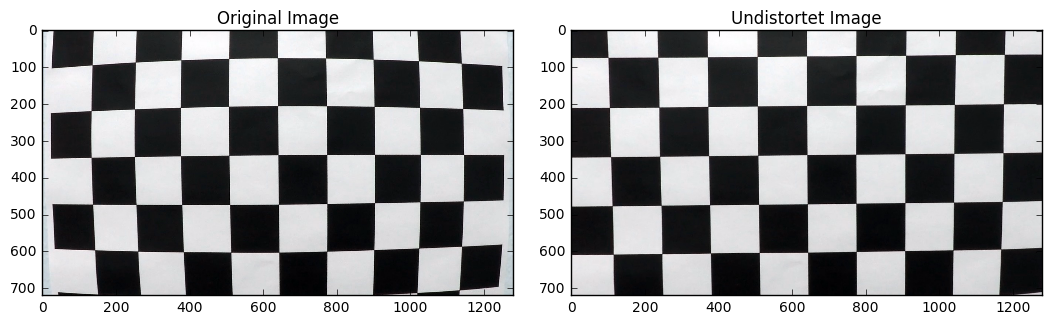

In [108]:
example_image = "./camera_cal/calibration1.jpg"
oimg = cv2.imread(example_image)
mtx, dist = calibrate(example_image, 9, 5)
uimg = undistort(oimg, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(uimg)
ax2.set_title('Undistortet Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholded Binary Image

* The original Image read via mpimg in the RGB colorspace

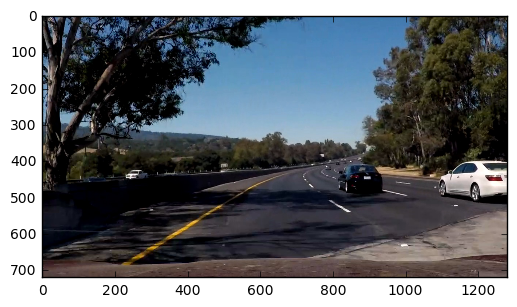

In [109]:
test_image = "./test_images/video_image1038.jpg"
oimg = mpimg.imread(test_image)
plt.imshow(oimg)

* The original image compared to the undistortet image (BGR colorspace)

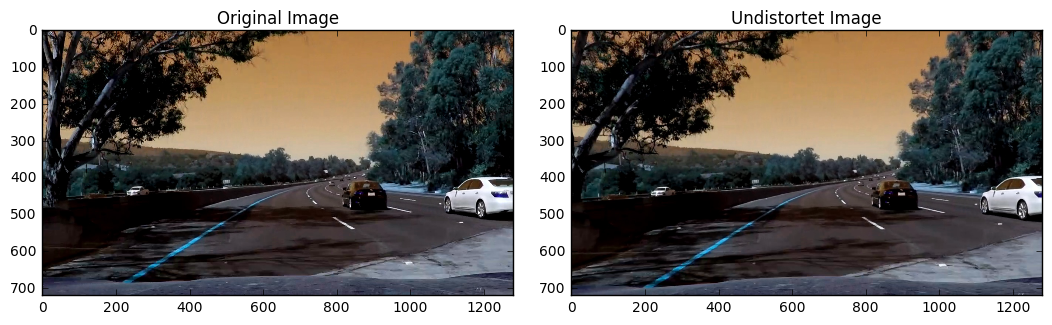

In [110]:
oimg = cv2.imread(test_image)
uimg = undistort(oimg, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(uimg)
ax2.set_title('Undistortet Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Several useful functions to experiment with

In [111]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt( sobelx**2 + sobely**2 )
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

ksize = 3
current_thresh = (20,100)

* Applying Sobel once in x and once in y orientation

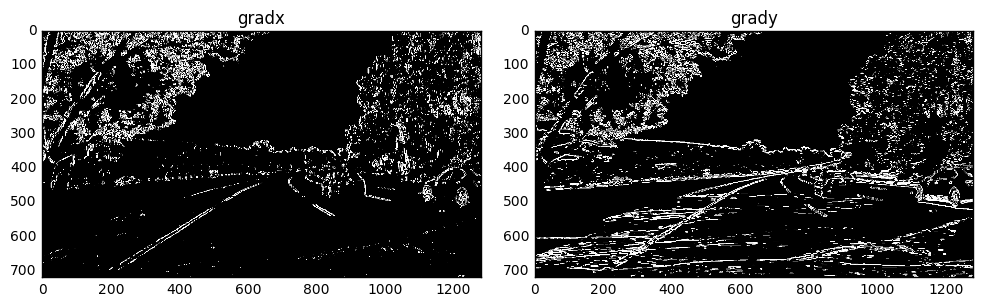

In [112]:
gradx = abs_sobel_thresh(uimg, orient='x', sobel_kernel=ksize, thresh=current_thresh)
grady = abs_sobel_thresh(uimg, orient='y', sobel_kernel=ksize, thresh=current_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(gradx, cmap="gray")
ax1.set_title('gradx', fontsize=12)
ax2.imshow(grady, cmap="gray")
ax2.set_title('grady', fontsize=12)

* Applying a threshold to the overall magnitude of the gradient, in x and y
* Direction of the gradient
* Combining the thresholds

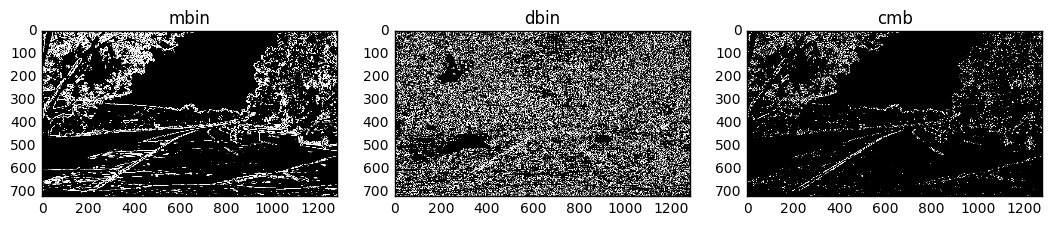

In [113]:
mag_binary = mag_thresh(uimg, sobel_kernel=ksize, thresh=current_thresh)
dir_binary = dir_threshold(uimg, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(mag_binary, cmap="gray")
ax1.set_title('mbin', fontsize=12)
ax2.imshow(dir_binary, cmap="gray")
ax2.set_title('dbin', fontsize=12)
ax3.imshow(combined, cmap="gray")
ax3.set_title('cmb', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Combining gradient thresholding with HLS color space

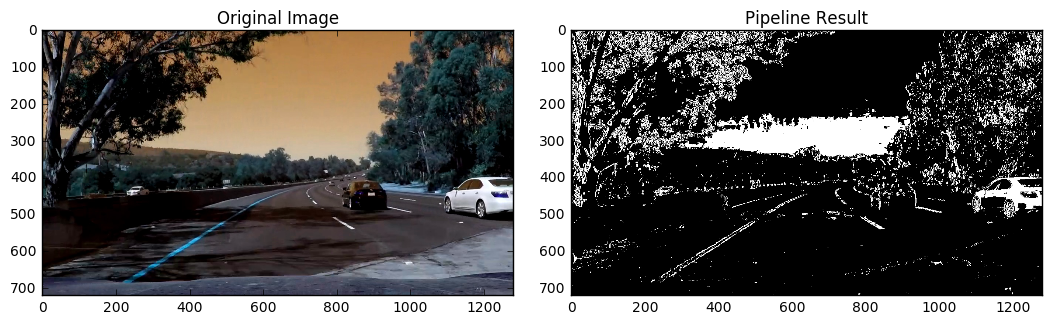

In [114]:
def pipeline(img, r_thresh=(200,255), s_thresh=(214, 230), h_thresh=(15,200), l_thresh=(20,100), sx_thresh=(20, 100)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # rgb
    r = img[:,:,0]
    r_binary = np.zeros_like(r)
    r_binary[(r > r_thresh[0]) & (r <= r_thresh[1])] = 1

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # gray
    g_thresh = (180, 255)
    g_binary = np.zeros_like(gray)
    g_binary[(gray > g_thresh[0]) & (gray <= g_thresh[1])] = 1

    # Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1) ] = 1

    return combined_binary
    
result = pipeline(oimg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

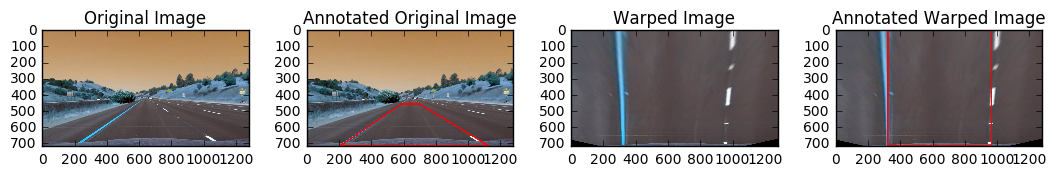

In [115]:
def warper(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
    matrix = cv2.getPerspectiveTransform(src,dst)
    return cv2.warpPerspective(img, matrix, img_size, flags=cv2.INTER_LINEAR)

test_image_straight_lines = "./test_images/straight_lines1.jpg"
uimg = undistort(cv2.imread(test_image_straight_lines), mtx, dist)
wimg = warper(uimg)

tmp_uimg = np.copy(uimg)
tmp_wimg = np.copy(wimg)

img_size = (uimg.shape[1], uimg.shape[0])

src_a = ( int((img_size[0] / 2) - 55), int(img_size[1] / 2 + 100) )
src_b = ( int((img_size[0] / 6) - 10), img_size[1] )
src_c = ( int((img_size[0] * 5 / 6) + 60), img_size[1] )
src_d = ( int(img_size[0] / 2 + 55), int(img_size[1] / 2 + 100) )

dst_a = ( int(img_size[0] / 4), 0 )
dst_b = ( int(img_size[0] / 4), img_size[1] )
dst_c = ( int(img_size[0] * 3 / 4), img_size[1] )
dst_d = ( int(img_size[0] * 3 / 4), 0 )

red = (255,0,0)
linethickness = 8

cv2.line(tmp_uimg, src_a, src_b, red, linethickness)
cv2.line(tmp_uimg, src_c, src_d, red, linethickness)
cv2.line(tmp_uimg, src_a, src_d, red, linethickness)
cv2.line(tmp_uimg, src_b, src_c, red, linethickness)

cv2.line(tmp_wimg, dst_a, dst_b, red, linethickness)
cv2.line(tmp_wimg, dst_c, dst_d, red, linethickness)
cv2.line(tmp_wimg, dst_a, dst_d, red, linethickness)
cv2.line(tmp_wimg, dst_b, dst_c, red, linethickness)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 8))
f.tight_layout()
ax1.imshow(uimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(tmp_uimg)
ax2.set_title('Annotated Original Image', fontsize=12)
ax3.imshow(wimg)
ax3.set_title('Warped Image', fontsize=12)
ax4.imshow(tmp_wimg)
ax4.set_title('Annotated Warped Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect Lane-Line Pixels

* Let's prepare a new 'curvy' image to work on

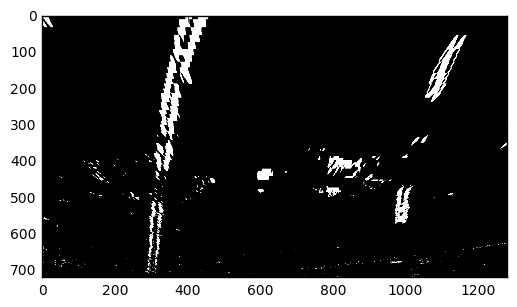

In [116]:
curvy_image = test_image

binary = pipeline(cv2.imread(curvy_image))

warper_binary = (warper(binary))

plt.imshow(warper_binary, cmap="gray")

* Let's see the histogram in the lower half of the warped image

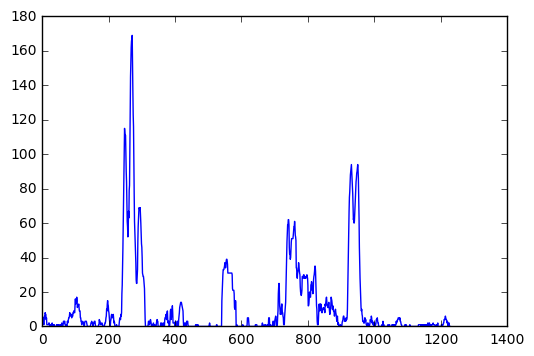

In [117]:
wimg = warper_binary
histogram = np.sum(wimg[wimg.shape[0]//2:,50:], axis=0)
plt.plot(histogram)

* Sliding Windows and fit a polynomial

In [118]:
# Create an output image to draw on and visualize the result later
out_img = np.dstack((wimg, wimg, wimg))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(wimg.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = wimg.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = wimg.shape[0] - (window+1)*window_height
    win_y_high = wimg.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# fit a polynomial of degree 2
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# plt.imshow(out_img)

* Let's visualise the result

(720, 0)

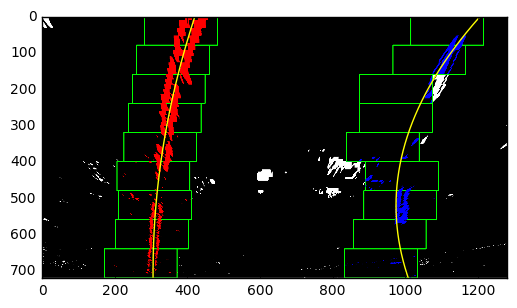

In [119]:
# Generate x and y values for plotting
ploty = np.linspace(0, wimg.shape[0]-1, wimg.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Radius of curvature

In [120]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

# position of car
def position_of_car(leftx, rightx, width):
    lane_width_in_pixels = rightx - leftx
    lane_center = (lane_width_in_pixels / 2) + leftx
    image_center = width / 2
    pixel_to_meter = lane_width_in_pixels / 3.7
    offset = (abs(lane_center - image_center))
    return (offset / pixel_to_meter)

print(position_of_car(leftx[0], rightx[0], wimg.shape[1]))

707.910027001 m 193.180325415 m
0.0944137931034


## Draw back on original image

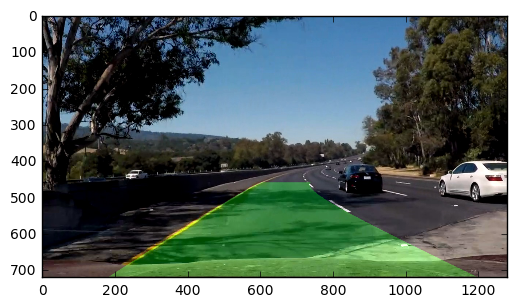

In [121]:
def draw_back(img, original_img, left_fitx, right_fitx, ploty):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
    minv = cv2.getPerspectiveTransform(dst,src)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result

final_image = cv2.cvtColor(draw_back(wimg, cv2.imread(curvy_image), left_fitx, right_fitx, ploty), cv2.COLOR_BGR2RGB)
plt.imshow(final_image)

## Video

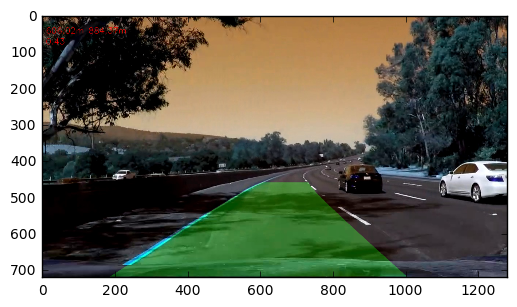

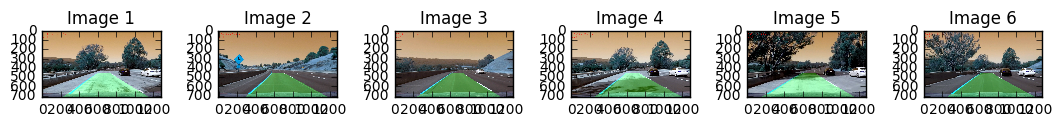

In [122]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

cache = deque(maxlen=100)
count = 0

def preprocess_image(img):
    return warper(pipeline(img))

def calc_peaks(histogram):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)


def calc_linepixelpositions(image, nwindows, leftx, rightx, margin=100, minpix=50):
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx - margin
        win_xleft_high = leftx + margin
        win_xright_low = rightx - margin
        win_xright_high = rightx + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty, rightx, righty)


def fit_polynomial(leftx, lefty, rightx, righty, ploty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (left_fitx, right_fitx)


def calc_radii(leftx, lefty, rightx, righty, ploty):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)


def insane(left_curverad, right_curverad, leftx, lefty, rightx, righty, image):
    return (
                left_curverad < 225 or 
                right_curverad < 225 or
                left_curverad > 
                leftx.size == 0 or
                lefty.size == 0 or
                rightx.size == 0 or
                righty.size == 0 or 
                position_of_car(leftx[0], rightx[0], image.shape[1]) > 0.45
    )


def annotate_image(image, left_curverad, right_curverad, car_position):
    left = str("{0:.2f}m ".format(left_curverad))
    right = str("{0:.2f}m ".format(right_curverad))
    t = left + right
    cv2.putText(image, t, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 1, cv2.LINE_AA)   
    t = str("{0:.2f}".format(car_position))
    cv2.putText(image, t, (10,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 1, cv2.LINE_AA)

def sameshape(a, b, c, d):
    return (a.shape == b.shape and a.shape == c.shape and a.shape == d.shape)

def process_image(original_image, nwindows = 9):
    image = preprocess_image(original_image)
    # Prepare Histogram 
    histogram = np.sum(image[image.shape[0]//2:,50:1230], axis=0)
    leftx_base, rightx_base = calc_peaks(histogram)
    leftx, lefty, rightx, righty = calc_linepixelpositions(image, nwindows, leftx_base, rightx_base)
    if(leftx.size != 0 and lefty.size != 0 and rightx.size != 0 and righty.size != 0):
        cache.append((leftx,lefty,rightx,righty))
    else:
        if(len(cache)==0):
            return original_image
        else:
            leftx, lefty, rightx, righty = cache.pop()
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    # Generate x and y values for plotting
    left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)
    left_curverad, right_curverad = calc_radii(leftx, lefty, rightx, righty, ploty)
    # Sanity Check
    while(insane(left_curverad, right_curverad, leftx, lefty, rightx, righty, image) and (len(cache)!=0)):
        leftx, lefty, rightx, righty = cache.pop()
        left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)
        left_curverad, right_curverad = calc_radii(leftx, lefty, rightx, righty, ploty)

    annotate_image(original_image, left_curverad, right_curverad, position_of_car(leftx[0], rightx[0], image.shape[1]))    
    return draw_back(image, original_image, left_fitx, right_fitx, ploty)


cache.clear()
test_image = "./test_images/video_image1040.jpg"
timg7 = process_image(cv2.imread(test_image))
timg1 = process_image(cv2.imread("./test_images/test1.jpg"))
timg2 = process_image(cv2.imread("./test_images/test2.jpg"))
timg3 = process_image(cv2.imread("./test_images/test3.jpg"))
timg4 = process_image(cv2.imread("./test_images/test4.jpg"))
timg5 = process_image(cv2.imread("./test_images/test5.jpg"))
timg6 = process_image(cv2.imread("./test_images/test6.jpg"))

plt.imshow(timg7, cmap='gray')

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(10, 8))
f.tight_layout()
ax1.imshow(timg1)
ax1.set_title('Image 1', fontsize=12)
ax2.imshow(timg2)
ax2.set_title('Image 2', fontsize=12)
ax3.imshow(timg3)
ax3.set_title('Image 3', fontsize=12)
ax4.imshow(timg4)
ax4.set_title('Image 4', fontsize=12)
ax5.imshow(timg5)
ax5.set_title('Image 5', fontsize=12)
ax6.imshow(timg6)
ax6.set_title('Image 6', fontsize=12)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [106]:
cache.clear()
output = "project_output_video.mp4"
clip = VideoFileClip("./project_video.mp4")
new_clip = clip.fl_image(process_image)
new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4


[MoviePy] Writing video project_output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:48,  7.47it/s]

  0%|          | 2/1261 [00:00<02:48,  7.45it/s]

  0%|          | 3/1261 [00:00<03:01,  6.91it/s]

  0%|          | 4/1261 [00:00<02:54,  7.19it/s]

  0%|          | 5/1261 [00:00<02:51,  7.34it/s]

  0%|          | 6/1261 [00:00<02:48,  7.43it/s]

  1%|          | 7/1261 [00:00<02:46,  7.52it/s]

  1%|          | 8/1261 [00:01<02:47,  7.47it/s]

  1%|          | 9/1261 [00:01<02:51,  7.30it/s]

  1%|          | 10/1261 [00:01<02:55,  7.13it/s]

  1%|          | 11/1261 [00:01<02:56,  7.07it/s]

  1%|          | 12/1261 [00:01<02:58,  7.00it/s]

  1%|          | 13/1261 [00:01<02:55,  7.13it/s]

  1%|          | 14/1261 [00:01<02:50,  7.31it/s]

  1%|          | 15/1261 [00:02<02:46,  7.49it/s]

  1%|▏         | 16/1261 [00:02<02:43,  7.63it/s]

  1%|▏         | 17/1261 [00:02<02:40,  7.73it/s]

  1%|▏         | 18/1261 [00:02<02:40,  7.75it/s]

  2%|▏         | 19/1261 [00:02<02:38,  7.82it/s]

  2%|▏         | 20/1261 [00:02<02:37,  7.86it/s]

  2%|▏         | 21/1261 [00:02<02:37,  7.88it/s]

  2%|▏         | 22/1261 [00:02<02:37,  7.88it/s]

  2%|▏         | 23/1261 [00:03<02:37,  7.88it/s]

  2%|▏         | 24/1261 [00:03<02:35,  7.98it/s]

  2%|▏         | 25/1261 [00:03<02:34,  8.02it/s]

  2%|▏         | 26/1261 [00:03<02:37,  7.85it/s]

  2%|▏         | 27/1261 [00:03<02:39,  7.76it/s]

  2%|▏         | 28/1261 [00:03<02:38,  7.79it/s]

  2%|▏         | 29/1261 [00:03<02:38,  7.78it/s]

  2%|▏         | 30/1261 [00:03<02:39,  7.70it/s]

  2%|▏         | 31/1261 [00:04<02:39,  7.72it/s]

  3%|▎         | 32/1261 [00:04<02:37,  7.79it/s]

  3%|▎         | 33/1261 [00:04<02:39,  7.69it/s]

  3%|▎         | 34/1261 [00:04<02:40,  7.66it/s]

  3%|▎         | 35/1261 [00:04<02:40,  7.62it/s]

  3%|▎         | 36/1261 [00:04<02:41,  7.61it/s]

  3%|▎         | 37/1261 [00:04<02:39,  7.65it/s]

  3%|▎         | 38/1261 [00:05<02:37,  7.75it/s]

  3%|▎         | 39/1261 [00:05<02:38,  7.73it/s]

  3%|▎         | 40/1261 [00:05<02:38,  7.68it/s]

  3%|▎         | 41/1261 [00:05<02:38,  7.69it/s]

  3%|▎         | 42/1261 [00:05<02:39,  7.65it/s]

  3%|▎         | 43/1261 [00:05<02:51,  7.11it/s]

  3%|▎         | 44/1261 [00:05<02:52,  7.07it/s]

  4%|▎         | 45/1261 [00:05<02:46,  7.30it/s]

  4%|▎         | 46/1261 [00:06<02:42,  7.48it/s]

  4%|▎         | 47/1261 [00:06<02:41,  7.50it/s]

  4%|▍         | 48/1261 [00:06<02:42,  7.47it/s]

  4%|▍         | 49/1261 [00:06<02:40,  7.54it/s]

  4%|▍         | 50/1261 [00:06<02:38,  7.63it/s]

  4%|▍         | 51/1261 [00:06<02:37,  7.70it/s]

  4%|▍         | 52/1261 [00:06<02:40,  7.54it/s]

  4%|▍         | 53/1261 [00:07<02:39,  7.57it/s]

  4%|▍         | 54/1261 [00:07<02:37,  7.65it/s]

  4%|▍         | 55/1261 [00:07<02:36,  7.69it/s]

  4%|▍         | 56/1261 [00:07<02:38,  7.62it/s]

  5%|▍         | 57/1261 [00:07<02:38,  7.59it/s]

  5%|▍         | 58/1261 [00:07<02:38,  7.57it/s]

  5%|▍         | 59/1261 [00:07<02:37,  7.61it/s]

  5%|▍         | 60/1261 [00:07<02:42,  7.41it/s]

  5%|▍         | 61/1261 [00:08<02:42,  7.37it/s]

  5%|▍         | 62/1261 [00:08<02:43,  7.33it/s]

  5%|▍         | 63/1261 [00:08<02:46,  7.18it/s]

  5%|▌         | 64/1261 [00:08<02:47,  7.13it/s]

  5%|▌         | 65/1261 [00:08<02:47,  7.14it/s]

  5%|▌         | 66/1261 [00:08<02:45,  7.21it/s]

  5%|▌         | 67/1261 [00:08<02:48,  7.09it/s]

  5%|▌         | 68/1261 [00:09<02:51,  6.98it/s]

  5%|▌         | 69/1261 [00:09<02:53,  6.86it/s]

  6%|▌         | 70/1261 [00:09<02:52,  6.91it/s]

  6%|▌         | 71/1261 [00:09<02:50,  6.99it/s]

  6%|▌         | 72/1261 [00:09<02:49,  7.02it/s]

  6%|▌         | 73/1261 [00:09<02:50,  6.99it/s]

  6%|▌         | 74/1261 [00:09<02:48,  7.05it/s]

  6%|▌         | 75/1261 [00:10<02:46,  7.10it/s]

  6%|▌         | 76/1261 [00:10<02:52,  6.86it/s]

  6%|▌         | 77/1261 [00:10<02:54,  6.77it/s]

  6%|▌         | 78/1261 [00:10<02:54,  6.80it/s]

  6%|▋         | 79/1261 [00:10<02:50,  6.92it/s]

  6%|▋         | 80/1261 [00:10<02:51,  6.88it/s]

  6%|▋         | 81/1261 [00:10<02:51,  6.89it/s]

  7%|▋         | 82/1261 [00:11<02:50,  6.91it/s]

  7%|▋         | 83/1261 [00:11<02:49,  6.95it/s]

  7%|▋         | 84/1261 [00:11<02:51,  6.86it/s]

  7%|▋         | 85/1261 [00:11<03:00,  6.51it/s]

  7%|▋         | 86/1261 [00:11<03:03,  6.42it/s]

  7%|▋         | 87/1261 [00:11<03:05,  6.31it/s]

  7%|▋         | 88/1261 [00:12<03:11,  6.13it/s]

  7%|▋         | 89/1261 [00:12<03:09,  6.17it/s]

  7%|▋         | 90/1261 [00:12<03:19,  5.88it/s]

  7%|▋         | 91/1261 [00:12<03:41,  5.29it/s]

  7%|▋         | 92/1261 [00:12<03:36,  5.40it/s]

  7%|▋         | 93/1261 [00:12<03:32,  5.50it/s]

  7%|▋         | 94/1261 [00:13<03:26,  5.65it/s]

  8%|▊         | 95/1261 [00:13<03:23,  5.72it/s]

  8%|▊         | 96/1261 [00:13<03:23,  5.73it/s]

  8%|▊         | 97/1261 [00:13<03:16,  5.93it/s]

  8%|▊         | 98/1261 [00:13<03:15,  5.95it/s]

  8%|▊         | 99/1261 [00:14<03:21,  5.76it/s]

  8%|▊         | 100/1261 [00:14<03:22,  5.73it/s]

  8%|▊         | 101/1261 [00:14<03:21,  5.75it/s]

  8%|▊         | 102/1261 [00:14<03:17,  5.86it/s]

  8%|▊         | 103/1261 [00:14<03:22,  5.72it/s]

  8%|▊         | 104/1261 [00:14<03:26,  5.59it/s]

  8%|▊         | 105/1261 [00:15<03:25,  5.63it/s]

  8%|▊         | 106/1261 [00:15<03:24,  5.65it/s]

  8%|▊         | 107/1261 [00:15<03:25,  5.63it/s]

  9%|▊         | 108/1261 [00:15<03:22,  5.70it/s]

  9%|▊         | 109/1261 [00:15<03:20,  5.73it/s]

  9%|▊         | 110/1261 [00:15<03:17,  5.82it/s]

  9%|▉         | 111/1261 [00:16<03:46,  5.08it/s]

  9%|▉         | 112/1261 [00:16<03:47,  5.06it/s]

  9%|▉         | 113/1261 [00:16<03:49,  5.00it/s]

  9%|▉         | 114/1261 [00:16<03:48,  5.03it/s]

  9%|▉         | 115/1261 [00:17<03:51,  4.94it/s]

  9%|▉         | 116/1261 [00:17<03:42,  5.14it/s]

  9%|▉         | 117/1261 [00:17<03:36,  5.29it/s]

  9%|▉         | 118/1261 [00:17<03:30,  5.42it/s]

  9%|▉         | 119/1261 [00:17<03:32,  5.37it/s]

 10%|▉         | 120/1261 [00:17<03:28,  5.46it/s]

 10%|▉         | 121/1261 [00:18<03:19,  5.71it/s]

 10%|▉         | 122/1261 [00:18<03:08,  6.03it/s]

 10%|▉         | 123/1261 [00:18<03:03,  6.19it/s]

 10%|▉         | 124/1261 [00:18<02:56,  6.43it/s]

 10%|▉         | 125/1261 [00:18<02:49,  6.70it/s]

 10%|▉         | 126/1261 [00:18<02:46,  6.83it/s]

 10%|█         | 127/1261 [00:18<02:45,  6.84it/s]

 10%|█         | 128/1261 [00:19<02:47,  6.78it/s]

 10%|█         | 129/1261 [00:19<02:48,  6.74it/s]

 10%|█         | 130/1261 [00:19<02:45,  6.82it/s]

 10%|█         | 131/1261 [00:19<02:42,  6.94it/s]

 10%|█         | 132/1261 [00:19<02:42,  6.96it/s]

 11%|█         | 133/1261 [00:19<02:42,  6.93it/s]

 11%|█         | 134/1261 [00:19<02:47,  6.72it/s]

 11%|█         | 135/1261 [00:20<02:55,  6.42it/s]

 11%|█         | 136/1261 [00:20<02:55,  6.40it/s]

 11%|█         | 137/1261 [00:20<02:51,  6.56it/s]

 11%|█         | 138/1261 [00:20<02:49,  6.63it/s]

 11%|█         | 139/1261 [00:20<02:53,  6.48it/s]

 11%|█         | 140/1261 [00:20<02:52,  6.51it/s]

 11%|█         | 141/1261 [00:21<02:52,  6.51it/s]

 11%|█▏        | 142/1261 [00:21<02:50,  6.57it/s]

 11%|█▏        | 143/1261 [00:21<02:51,  6.51it/s]

 11%|█▏        | 144/1261 [00:21<02:48,  6.63it/s]

 11%|█▏        | 145/1261 [00:21<02:44,  6.80it/s]

 12%|█▏        | 146/1261 [00:21<02:42,  6.85it/s]

 12%|█▏        | 147/1261 [00:21<02:46,  6.68it/s]

 12%|█▏        | 148/1261 [00:22<02:46,  6.70it/s]

 12%|█▏        | 149/1261 [00:22<02:40,  6.92it/s]

 12%|█▏        | 150/1261 [00:22<02:35,  7.13it/s]

 12%|█▏        | 151/1261 [00:22<02:36,  7.11it/s]

 12%|█▏        | 152/1261 [00:22<02:35,  7.14it/s]

 12%|█▏        | 153/1261 [00:22<02:34,  7.19it/s]

 12%|█▏        | 154/1261 [00:22<02:34,  7.18it/s]

 12%|█▏        | 155/1261 [00:23<02:36,  7.07it/s]

 12%|█▏        | 156/1261 [00:23<02:37,  7.02it/s]

 12%|█▏        | 157/1261 [00:23<02:43,  6.76it/s]

 13%|█▎        | 158/1261 [00:23<02:43,  6.74it/s]

 13%|█▎        | 159/1261 [00:23<02:47,  6.58it/s]

 13%|█▎        | 160/1261 [00:23<02:44,  6.71it/s]

 13%|█▎        | 161/1261 [00:23<02:49,  6.51it/s]

 13%|█▎        | 162/1261 [00:24<02:54,  6.29it/s]

 13%|█▎        | 163/1261 [00:24<02:55,  6.25it/s]

 13%|█▎        | 164/1261 [00:24<02:53,  6.31it/s]

 13%|█▎        | 165/1261 [00:24<02:52,  6.36it/s]

 13%|█▎        | 166/1261 [00:24<02:55,  6.25it/s]

 13%|█▎        | 167/1261 [00:24<02:57,  6.16it/s]

 13%|█▎        | 168/1261 [00:25<02:58,  6.13it/s]

 13%|█▎        | 169/1261 [00:25<02:58,  6.13it/s]

 13%|█▎        | 170/1261 [00:25<02:58,  6.10it/s]

 14%|█▎        | 171/1261 [00:25<03:00,  6.03it/s]

 14%|█▎        | 172/1261 [00:25<03:00,  6.03it/s]

 14%|█▎        | 173/1261 [00:25<02:56,  6.16it/s]

 14%|█▍        | 174/1261 [00:26<02:46,  6.51it/s]

 14%|█▍        | 175/1261 [00:26<02:42,  6.69it/s]

 14%|█▍        | 176/1261 [00:26<02:36,  6.93it/s]

 14%|█▍        | 177/1261 [00:26<02:32,  7.11it/s]

 14%|█▍        | 178/1261 [00:26<02:29,  7.27it/s]

 14%|█▍        | 179/1261 [00:26<02:32,  7.11it/s]

 14%|█▍        | 180/1261 [00:26<02:37,  6.88it/s]

 14%|█▍        | 181/1261 [00:27<02:40,  6.71it/s]

 14%|█▍        | 182/1261 [00:27<02:41,  6.67it/s]

 15%|█▍        | 183/1261 [00:27<02:46,  6.47it/s]

 15%|█▍        | 184/1261 [00:27<02:43,  6.58it/s]

 15%|█▍        | 185/1261 [00:27<02:40,  6.71it/s]

 15%|█▍        | 186/1261 [00:27<02:42,  6.63it/s]

 15%|█▍        | 187/1261 [00:27<02:47,  6.41it/s]

 15%|█▍        | 188/1261 [00:28<02:45,  6.47it/s]

 15%|█▍        | 189/1261 [00:28<02:45,  6.48it/s]

 15%|█▌        | 190/1261 [00:28<02:43,  6.55it/s]

 15%|█▌        | 191/1261 [00:28<02:46,  6.43it/s]

 15%|█▌        | 192/1261 [00:28<02:45,  6.45it/s]

 15%|█▌        | 193/1261 [00:28<02:41,  6.63it/s]

 15%|█▌        | 194/1261 [00:29<02:37,  6.76it/s]

 15%|█▌        | 195/1261 [00:29<02:40,  6.62it/s]

 16%|█▌        | 196/1261 [00:29<02:37,  6.74it/s]

 16%|█▌        | 197/1261 [00:29<02:36,  6.79it/s]

 16%|█▌        | 198/1261 [00:29<02:33,  6.94it/s]

 16%|█▌        | 199/1261 [00:29<02:36,  6.81it/s]

 16%|█▌        | 200/1261 [00:29<02:38,  6.68it/s]

 16%|█▌        | 201/1261 [00:30<02:42,  6.54it/s]

 16%|█▌        | 202/1261 [00:30<02:47,  6.34it/s]

 16%|█▌        | 203/1261 [00:30<02:49,  6.25it/s]

 16%|█▌        | 204/1261 [00:30<02:48,  6.28it/s]

 16%|█▋        | 205/1261 [00:30<02:47,  6.29it/s]

 16%|█▋        | 206/1261 [00:30<02:46,  6.35it/s]

 16%|█▋        | 207/1261 [00:31<02:45,  6.37it/s]

 16%|█▋        | 208/1261 [00:31<02:42,  6.47it/s]

 17%|█▋        | 209/1261 [00:31<02:38,  6.66it/s]

 17%|█▋        | 210/1261 [00:31<02:37,  6.66it/s]

 17%|█▋        | 211/1261 [00:31<02:42,  6.47it/s]

 17%|█▋        | 212/1261 [00:31<02:42,  6.44it/s]

 17%|█▋        | 213/1261 [00:31<02:39,  6.57it/s]

 17%|█▋        | 214/1261 [00:32<02:37,  6.63it/s]

 17%|█▋        | 215/1261 [00:32<02:39,  6.54it/s]

 17%|█▋        | 216/1261 [00:32<02:42,  6.43it/s]

 17%|█▋        | 217/1261 [00:32<02:48,  6.21it/s]

 17%|█▋        | 218/1261 [00:32<02:48,  6.18it/s]

 17%|█▋        | 219/1261 [00:32<02:51,  6.09it/s]

 17%|█▋        | 220/1261 [00:33<02:48,  6.17it/s]

 18%|█▊        | 221/1261 [00:33<02:47,  6.22it/s]

 18%|█▊        | 222/1261 [00:33<02:52,  6.02it/s]

 18%|█▊        | 223/1261 [00:33<02:57,  5.84it/s]

 18%|█▊        | 224/1261 [00:33<02:52,  6.00it/s]

 18%|█▊        | 225/1261 [00:33<02:48,  6.15it/s]

 18%|█▊        | 226/1261 [00:34<02:47,  6.18it/s]

 18%|█▊        | 227/1261 [00:34<02:49,  6.09it/s]

 18%|█▊        | 228/1261 [00:34<02:51,  6.03it/s]

 18%|█▊        | 229/1261 [00:34<02:49,  6.09it/s]

 18%|█▊        | 230/1261 [00:34<02:53,  5.96it/s]

 18%|█▊        | 231/1261 [00:34<02:55,  5.88it/s]

 18%|█▊        | 232/1261 [00:35<02:53,  5.94it/s]

 18%|█▊        | 233/1261 [00:35<02:49,  6.08it/s]

 19%|█▊        | 234/1261 [00:35<02:45,  6.20it/s]

 19%|█▊        | 235/1261 [00:35<02:47,  6.11it/s]

 19%|█▊        | 236/1261 [00:35<02:47,  6.13it/s]

 19%|█▉        | 237/1261 [00:35<02:43,  6.26it/s]

 19%|█▉        | 238/1261 [00:36<02:39,  6.43it/s]

 19%|█▉        | 239/1261 [00:36<02:40,  6.38it/s]

 19%|█▉        | 240/1261 [00:36<02:38,  6.44it/s]

 19%|█▉        | 241/1261 [00:36<02:36,  6.53it/s]

 19%|█▉        | 242/1261 [00:36<02:43,  6.23it/s]

 19%|█▉        | 243/1261 [00:36<02:44,  6.17it/s]

 19%|█▉        | 244/1261 [00:36<02:47,  6.08it/s]

 19%|█▉        | 245/1261 [00:37<02:43,  6.20it/s]

 20%|█▉        | 246/1261 [00:37<02:40,  6.31it/s]

 20%|█▉        | 247/1261 [00:37<02:40,  6.31it/s]

 20%|█▉        | 248/1261 [00:37<02:36,  6.49it/s]

 20%|█▉        | 249/1261 [00:37<02:30,  6.74it/s]

 20%|█▉        | 250/1261 [00:37<02:25,  6.95it/s]

 20%|█▉        | 251/1261 [00:38<02:28,  6.82it/s]

 20%|█▉        | 252/1261 [00:38<02:32,  6.61it/s]

 20%|██        | 253/1261 [00:38<02:32,  6.59it/s]

 20%|██        | 254/1261 [00:38<02:29,  6.73it/s]

 20%|██        | 255/1261 [00:38<02:28,  6.78it/s]

 20%|██        | 256/1261 [00:38<02:26,  6.88it/s]

 20%|██        | 257/1261 [00:38<02:24,  6.97it/s]

 20%|██        | 258/1261 [00:39<02:24,  6.93it/s]

 21%|██        | 259/1261 [00:39<02:29,  6.68it/s]

 21%|██        | 260/1261 [00:39<02:26,  6.84it/s]

 21%|██        | 261/1261 [00:39<02:23,  6.96it/s]

 21%|██        | 262/1261 [00:39<02:23,  6.96it/s]

 21%|██        | 263/1261 [00:39<02:26,  6.81it/s]

 21%|██        | 264/1261 [00:39<02:28,  6.72it/s]

 21%|██        | 265/1261 [00:40<02:27,  6.75it/s]

 21%|██        | 266/1261 [00:40<02:26,  6.80it/s]

 21%|██        | 267/1261 [00:40<02:29,  6.67it/s]

 21%|██▏       | 268/1261 [00:40<02:33,  6.47it/s]

 21%|██▏       | 269/1261 [00:40<02:31,  6.56it/s]

 21%|██▏       | 270/1261 [00:40<02:28,  6.67it/s]

 21%|██▏       | 271/1261 [00:40<02:30,  6.59it/s]

 22%|██▏       | 272/1261 [00:41<02:29,  6.60it/s]

 22%|██▏       | 273/1261 [00:41<02:29,  6.61it/s]

 22%|██▏       | 274/1261 [00:41<02:31,  6.52it/s]

 22%|██▏       | 275/1261 [00:41<02:36,  6.31it/s]

 22%|██▏       | 276/1261 [00:41<02:33,  6.43it/s]

 22%|██▏       | 277/1261 [00:41<02:27,  6.65it/s]

 22%|██▏       | 278/1261 [00:42<02:26,  6.72it/s]

 22%|██▏       | 279/1261 [00:42<02:28,  6.61it/s]

 22%|██▏       | 280/1261 [00:42<02:28,  6.61it/s]

 22%|██▏       | 281/1261 [00:42<02:27,  6.65it/s]

 22%|██▏       | 282/1261 [00:42<02:25,  6.73it/s]

 22%|██▏       | 283/1261 [00:42<02:25,  6.70it/s]

 23%|██▎       | 284/1261 [00:42<02:25,  6.71it/s]

 23%|██▎       | 285/1261 [00:43<02:25,  6.73it/s]

 23%|██▎       | 286/1261 [00:43<02:27,  6.63it/s]

 23%|██▎       | 287/1261 [00:43<02:32,  6.40it/s]

 23%|██▎       | 288/1261 [00:43<02:35,  6.26it/s]

 23%|██▎       | 289/1261 [00:43<02:35,  6.24it/s]

 23%|██▎       | 290/1261 [00:43<02:42,  5.97it/s]

 23%|██▎       | 291/1261 [00:44<02:43,  5.95it/s]

 23%|██▎       | 292/1261 [00:44<02:40,  6.03it/s]

 23%|██▎       | 293/1261 [00:44<02:42,  5.95it/s]

 23%|██▎       | 294/1261 [00:44<02:39,  6.07it/s]

 23%|██▎       | 295/1261 [00:44<02:36,  6.16it/s]

 23%|██▎       | 296/1261 [00:44<02:34,  6.25it/s]

 24%|██▎       | 297/1261 [00:45<02:35,  6.20it/s]

 24%|██▎       | 298/1261 [00:45<02:36,  6.13it/s]

 24%|██▎       | 299/1261 [00:45<02:37,  6.12it/s]

 24%|██▍       | 300/1261 [00:45<02:37,  6.10it/s]

 24%|██▍       | 301/1261 [00:45<02:39,  6.02it/s]

 24%|██▍       | 302/1261 [00:45<02:38,  6.07it/s]

 24%|██▍       | 303/1261 [00:46<02:36,  6.12it/s]

 24%|██▍       | 304/1261 [00:46<02:34,  6.18it/s]

 24%|██▍       | 305/1261 [00:46<02:33,  6.25it/s]

 24%|██▍       | 306/1261 [00:46<02:40,  5.96it/s]

 24%|██▍       | 307/1261 [00:46<02:43,  5.83it/s]

 24%|██▍       | 308/1261 [00:46<02:41,  5.90it/s]

 25%|██▍       | 309/1261 [00:47<02:39,  5.96it/s]

 25%|██▍       | 310/1261 [00:47<02:40,  5.92it/s]

 25%|██▍       | 311/1261 [00:47<02:36,  6.08it/s]

 25%|██▍       | 312/1261 [00:47<02:31,  6.27it/s]

 25%|██▍       | 313/1261 [00:47<02:31,  6.27it/s]

 25%|██▍       | 314/1261 [00:47<02:32,  6.19it/s]

 25%|██▍       | 315/1261 [00:48<02:32,  6.20it/s]

 25%|██▌       | 316/1261 [00:48<02:33,  6.14it/s]

 25%|██▌       | 317/1261 [00:48<02:28,  6.35it/s]

 25%|██▌       | 318/1261 [00:48<02:26,  6.42it/s]

 25%|██▌       | 319/1261 [00:48<02:21,  6.65it/s]

 25%|██▌       | 320/1261 [00:48<02:19,  6.76it/s]

 25%|██▌       | 321/1261 [00:48<02:18,  6.80it/s]

 26%|██▌       | 322/1261 [00:49<02:20,  6.69it/s]

 26%|██▌       | 323/1261 [00:49<02:20,  6.68it/s]

 26%|██▌       | 324/1261 [00:49<02:19,  6.72it/s]

 26%|██▌       | 325/1261 [00:49<02:17,  6.82it/s]

 26%|██▌       | 326/1261 [00:49<02:17,  6.82it/s]

 26%|██▌       | 327/1261 [00:49<02:15,  6.91it/s]

 26%|██▌       | 328/1261 [00:49<02:12,  7.02it/s]

 26%|██▌       | 329/1261 [00:50<02:10,  7.12it/s]

 26%|██▌       | 330/1261 [00:50<02:12,  7.02it/s]

 26%|██▌       | 331/1261 [00:50<02:15,  6.87it/s]

 26%|██▋       | 332/1261 [00:50<02:14,  6.88it/s]

 26%|██▋       | 333/1261 [00:50<02:14,  6.89it/s]

 26%|██▋       | 334/1261 [00:50<02:13,  6.93it/s]

 27%|██▋       | 335/1261 [00:50<02:10,  7.08it/s]

 27%|██▋       | 336/1261 [00:51<02:08,  7.22it/s]

 27%|██▋       | 337/1261 [00:51<02:08,  7.18it/s]

 27%|██▋       | 338/1261 [00:51<02:10,  7.09it/s]

 27%|██▋       | 339/1261 [00:51<02:15,  6.79it/s]

 27%|██▋       | 340/1261 [00:51<02:17,  6.68it/s]

 27%|██▋       | 341/1261 [00:51<02:13,  6.87it/s]

 27%|██▋       | 342/1261 [00:51<02:15,  6.78it/s]

 27%|██▋       | 343/1261 [00:52<02:14,  6.83it/s]

 27%|██▋       | 344/1261 [00:52<02:13,  6.86it/s]

 27%|██▋       | 345/1261 [00:52<02:13,  6.88it/s]

 27%|██▋       | 346/1261 [00:52<02:16,  6.68it/s]

 28%|██▊       | 347/1261 [00:52<02:15,  6.75it/s]

 28%|██▊       | 348/1261 [00:52<02:12,  6.89it/s]

 28%|██▊       | 349/1261 [00:53<02:17,  6.63it/s]

 28%|██▊       | 350/1261 [00:53<02:24,  6.31it/s]

 28%|██▊       | 351/1261 [00:53<02:25,  6.28it/s]

 28%|██▊       | 352/1261 [00:53<02:26,  6.22it/s]

 28%|██▊       | 353/1261 [00:53<02:21,  6.42it/s]

 28%|██▊       | 354/1261 [00:53<02:25,  6.21it/s]

 28%|██▊       | 355/1261 [00:53<02:26,  6.19it/s]

 28%|██▊       | 356/1261 [00:54<02:25,  6.20it/s]

 28%|██▊       | 357/1261 [00:54<02:24,  6.26it/s]

 28%|██▊       | 358/1261 [00:54<02:25,  6.19it/s]

 28%|██▊       | 359/1261 [00:54<02:26,  6.17it/s]

 29%|██▊       | 360/1261 [00:54<02:30,  5.98it/s]

 29%|██▊       | 361/1261 [00:54<02:28,  6.07it/s]

 29%|██▊       | 362/1261 [00:55<02:26,  6.16it/s]

 29%|██▉       | 363/1261 [00:55<02:25,  6.18it/s]

 29%|██▉       | 364/1261 [00:55<02:22,  6.29it/s]

 29%|██▉       | 365/1261 [00:55<02:21,  6.34it/s]

 29%|██▉       | 366/1261 [00:55<02:24,  6.18it/s]

 29%|██▉       | 367/1261 [00:55<02:26,  6.11it/s]

 29%|██▉       | 368/1261 [00:56<02:25,  6.15it/s]

 29%|██▉       | 369/1261 [00:56<02:21,  6.31it/s]

 29%|██▉       | 370/1261 [00:56<02:21,  6.31it/s]

 29%|██▉       | 371/1261 [00:56<02:21,  6.29it/s]

 30%|██▉       | 372/1261 [00:56<02:21,  6.30it/s]

 30%|██▉       | 373/1261 [00:56<02:20,  6.33it/s]

 30%|██▉       | 374/1261 [00:57<02:26,  6.04it/s]

 30%|██▉       | 375/1261 [00:57<02:26,  6.05it/s]

 30%|██▉       | 376/1261 [00:57<02:24,  6.11it/s]

 30%|██▉       | 377/1261 [00:57<02:21,  6.24it/s]

 30%|██▉       | 378/1261 [00:57<02:24,  6.11it/s]

 30%|███       | 379/1261 [00:57<02:24,  6.11it/s]

 30%|███       | 380/1261 [00:58<02:22,  6.19it/s]

 30%|███       | 381/1261 [00:58<02:21,  6.23it/s]

 30%|███       | 382/1261 [00:58<02:24,  6.09it/s]

 30%|███       | 383/1261 [00:58<02:23,  6.11it/s]

 30%|███       | 384/1261 [00:58<02:21,  6.18it/s]

 31%|███       | 385/1261 [00:58<02:20,  6.25it/s]

 31%|███       | 386/1261 [00:59<02:24,  6.05it/s]

 31%|███       | 387/1261 [00:59<02:26,  5.97it/s]

 31%|███       | 388/1261 [00:59<02:27,  5.92it/s]

 31%|███       | 389/1261 [00:59<02:23,  6.07it/s]

 31%|███       | 390/1261 [00:59<02:25,  5.97it/s]

 31%|███       | 391/1261 [00:59<02:25,  6.00it/s]

 31%|███       | 392/1261 [01:00<02:23,  6.07it/s]

 31%|███       | 393/1261 [01:00<02:23,  6.05it/s]

 31%|███       | 394/1261 [01:00<02:23,  6.05it/s]

 31%|███▏      | 395/1261 [01:00<02:23,  6.03it/s]

 31%|███▏      | 396/1261 [01:00<02:20,  6.16it/s]

 31%|███▏      | 397/1261 [01:00<02:16,  6.34it/s]

 32%|███▏      | 398/1261 [01:00<02:19,  6.17it/s]

 32%|███▏      | 399/1261 [01:01<02:21,  6.08it/s]

 32%|███▏      | 400/1261 [01:01<02:23,  6.02it/s]

 32%|███▏      | 401/1261 [01:01<02:28,  5.80it/s]

 32%|███▏      | 402/1261 [01:01<02:34,  5.56it/s]

 32%|███▏      | 403/1261 [01:01<02:28,  5.76it/s]

 32%|███▏      | 404/1261 [01:02<02:24,  5.92it/s]

 32%|███▏      | 405/1261 [01:02<02:22,  5.99it/s]

 32%|███▏      | 406/1261 [01:02<02:22,  5.99it/s]

 32%|███▏      | 407/1261 [01:02<02:18,  6.15it/s]

 32%|███▏      | 408/1261 [01:02<02:14,  6.36it/s]

 32%|███▏      | 409/1261 [01:02<02:12,  6.41it/s]

 33%|███▎      | 410/1261 [01:02<02:14,  6.31it/s]

 33%|███▎      | 411/1261 [01:03<02:17,  6.18it/s]

 33%|███▎      | 412/1261 [01:03<02:18,  6.15it/s]

 33%|███▎      | 413/1261 [01:03<02:17,  6.18it/s]

 33%|███▎      | 414/1261 [01:03<02:15,  6.23it/s]

 33%|███▎      | 415/1261 [01:03<02:15,  6.23it/s]

 33%|███▎      | 416/1261 [01:03<02:14,  6.29it/s]

 33%|███▎      | 417/1261 [01:04<02:16,  6.16it/s]

 33%|███▎      | 418/1261 [01:04<02:20,  6.02it/s]

 33%|███▎      | 419/1261 [01:04<02:19,  6.03it/s]

 33%|███▎      | 420/1261 [01:04<02:17,  6.12it/s]

 33%|███▎      | 421/1261 [01:04<02:14,  6.23it/s]

 33%|███▎      | 422/1261 [01:04<02:17,  6.12it/s]

 34%|███▎      | 423/1261 [01:05<02:15,  6.19it/s]

 34%|███▎      | 424/1261 [01:05<02:13,  6.29it/s]

 34%|███▎      | 425/1261 [01:05<02:10,  6.39it/s]

 34%|███▍      | 426/1261 [01:05<02:13,  6.25it/s]

 34%|███▍      | 427/1261 [01:05<02:13,  6.26it/s]

 34%|███▍      | 428/1261 [01:05<02:08,  6.47it/s]

 34%|███▍      | 429/1261 [01:06<02:10,  6.39it/s]

 34%|███▍      | 430/1261 [01:06<02:11,  6.31it/s]

 34%|███▍      | 431/1261 [01:06<02:10,  6.35it/s]

 34%|███▍      | 432/1261 [01:06<02:11,  6.29it/s]

 34%|███▍      | 433/1261 [01:06<02:15,  6.13it/s]

 34%|███▍      | 434/1261 [01:06<02:13,  6.18it/s]

 34%|███▍      | 435/1261 [01:06<02:11,  6.28it/s]

 35%|███▍      | 436/1261 [01:07<02:10,  6.34it/s]

 35%|███▍      | 437/1261 [01:07<02:10,  6.32it/s]

 35%|███▍      | 438/1261 [01:07<02:12,  6.23it/s]

 35%|███▍      | 439/1261 [01:07<02:12,  6.21it/s]

 35%|███▍      | 440/1261 [01:07<02:11,  6.22it/s]

 35%|███▍      | 441/1261 [01:07<02:11,  6.24it/s]

 35%|███▌      | 442/1261 [01:08<02:11,  6.22it/s]

 35%|███▌      | 443/1261 [01:08<02:09,  6.30it/s]

 35%|███▌      | 444/1261 [01:08<02:07,  6.41it/s]

 35%|███▌      | 445/1261 [01:08<02:06,  6.44it/s]

 35%|███▌      | 446/1261 [01:08<02:07,  6.40it/s]

 35%|███▌      | 447/1261 [01:08<02:05,  6.51it/s]

 36%|███▌      | 448/1261 [01:09<02:03,  6.57it/s]

 36%|███▌      | 449/1261 [01:09<02:01,  6.69it/s]

 36%|███▌      | 450/1261 [01:09<02:05,  6.47it/s]

 36%|███▌      | 451/1261 [01:09<02:04,  6.52it/s]

 36%|███▌      | 452/1261 [01:09<02:07,  6.37it/s]

 36%|███▌      | 453/1261 [01:09<02:02,  6.58it/s]

 36%|███▌      | 454/1261 [01:09<02:03,  6.55it/s]

 36%|███▌      | 455/1261 [01:10<02:03,  6.54it/s]

 36%|███▌      | 456/1261 [01:10<02:04,  6.44it/s]

 36%|███▌      | 457/1261 [01:10<02:06,  6.35it/s]

 36%|███▋      | 458/1261 [01:10<02:10,  6.15it/s]

 36%|███▋      | 459/1261 [01:10<02:12,  6.03it/s]

 36%|███▋      | 460/1261 [01:10<02:10,  6.15it/s]

 37%|███▋      | 461/1261 [01:11<02:11,  6.07it/s]

 37%|███▋      | 462/1261 [01:11<02:14,  5.94it/s]

 37%|███▋      | 463/1261 [01:11<02:14,  5.95it/s]

 37%|███▋      | 464/1261 [01:11<02:19,  5.73it/s]

 37%|███▋      | 465/1261 [01:11<02:17,  5.80it/s]

 37%|███▋      | 466/1261 [01:11<02:18,  5.74it/s]

 37%|███▋      | 467/1261 [01:12<02:15,  5.85it/s]

 37%|███▋      | 468/1261 [01:12<02:11,  6.02it/s]

 37%|███▋      | 469/1261 [01:12<02:12,  5.99it/s]

 37%|███▋      | 470/1261 [01:12<02:16,  5.80it/s]

 37%|███▋      | 471/1261 [01:12<02:19,  5.66it/s]

 37%|███▋      | 472/1261 [01:13<02:19,  5.64it/s]

 38%|███▊      | 473/1261 [01:13<02:18,  5.69it/s]

 38%|███▊      | 474/1261 [01:13<02:21,  5.56it/s]

 38%|███▊      | 475/1261 [01:13<02:18,  5.67it/s]

 38%|███▊      | 476/1261 [01:13<02:19,  5.62it/s]

 38%|███▊      | 477/1261 [01:13<02:20,  5.57it/s]

 38%|███▊      | 478/1261 [01:14<02:22,  5.51it/s]

 38%|███▊      | 479/1261 [01:14<02:21,  5.52it/s]

 38%|███▊      | 480/1261 [01:14<02:20,  5.55it/s]

 38%|███▊      | 481/1261 [01:14<02:19,  5.59it/s]

 38%|███▊      | 482/1261 [01:14<02:21,  5.51it/s]

 38%|███▊      | 483/1261 [01:14<02:18,  5.61it/s]

 38%|███▊      | 484/1261 [01:15<02:19,  5.59it/s]

 38%|███▊      | 485/1261 [01:15<02:17,  5.63it/s]

 39%|███▊      | 486/1261 [01:15<02:21,  5.47it/s]

 39%|███▊      | 487/1261 [01:15<02:23,  5.40it/s]

 39%|███▊      | 488/1261 [01:15<02:23,  5.39it/s]

 39%|███▉      | 489/1261 [01:16<02:23,  5.39it/s]

 39%|███▉      | 490/1261 [01:16<02:23,  5.39it/s]

 39%|███▉      | 491/1261 [01:16<02:25,  5.29it/s]

 39%|███▉      | 492/1261 [01:16<02:28,  5.17it/s]

 39%|███▉      | 493/1261 [01:16<02:26,  5.24it/s]

 39%|███▉      | 494/1261 [01:17<02:29,  5.14it/s]

 39%|███▉      | 495/1261 [01:17<02:27,  5.19it/s]

 39%|███▉      | 496/1261 [01:17<02:24,  5.30it/s]

 39%|███▉      | 497/1261 [01:17<02:19,  5.48it/s]

 39%|███▉      | 498/1261 [01:17<02:18,  5.50it/s]

 40%|███▉      | 499/1261 [01:17<02:16,  5.59it/s]

 40%|███▉      | 500/1261 [01:18<02:12,  5.76it/s]

 40%|███▉      | 501/1261 [01:18<02:10,  5.82it/s]

 40%|███▉      | 502/1261 [01:18<02:13,  5.69it/s]

 40%|███▉      | 503/1261 [01:18<02:14,  5.63it/s]

 40%|███▉      | 504/1261 [01:18<02:17,  5.49it/s]

 40%|████      | 505/1261 [01:19<02:22,  5.31it/s]

 40%|████      | 506/1261 [01:19<02:25,  5.20it/s]

 40%|████      | 507/1261 [01:19<02:36,  4.83it/s]

 40%|████      | 508/1261 [01:19<02:40,  4.69it/s]

 40%|████      | 509/1261 [01:19<02:38,  4.74it/s]

 40%|████      | 510/1261 [01:20<02:36,  4.79it/s]

 41%|████      | 511/1261 [01:20<02:33,  4.90it/s]

 41%|████      | 512/1261 [01:20<02:33,  4.87it/s]

 41%|████      | 513/1261 [01:20<02:34,  4.86it/s]

 41%|████      | 514/1261 [01:20<02:36,  4.76it/s]

 41%|████      | 515/1261 [01:21<02:34,  4.84it/s]

 41%|████      | 516/1261 [01:21<02:29,  4.97it/s]

 41%|████      | 517/1261 [01:21<02:29,  4.99it/s]

 41%|████      | 518/1261 [01:21<02:37,  4.72it/s]

 41%|████      | 519/1261 [01:21<02:32,  4.86it/s]

 41%|████      | 520/1261 [01:22<02:31,  4.89it/s]

 41%|████▏     | 521/1261 [01:22<02:29,  4.94it/s]

 41%|████▏     | 522/1261 [01:22<02:42,  4.54it/s]

 41%|████▏     | 523/1261 [01:22<02:37,  4.67it/s]

 42%|████▏     | 524/1261 [01:23<02:36,  4.71it/s]

 42%|████▏     | 525/1261 [01:23<02:29,  4.91it/s]

 42%|████▏     | 526/1261 [01:23<02:25,  5.05it/s]

 42%|████▏     | 527/1261 [01:23<02:20,  5.23it/s]

 42%|████▏     | 528/1261 [01:23<02:17,  5.34it/s]

 42%|████▏     | 529/1261 [01:23<02:14,  5.45it/s]

 42%|████▏     | 530/1261 [01:24<02:10,  5.62it/s]

 42%|████▏     | 531/1261 [01:24<02:05,  5.80it/s]

 42%|████▏     | 532/1261 [01:24<02:00,  6.07it/s]

 42%|████▏     | 533/1261 [01:24<01:53,  6.41it/s]

 42%|████▏     | 534/1261 [01:24<01:52,  6.44it/s]

 42%|████▏     | 535/1261 [01:24<01:52,  6.47it/s]

 43%|████▎     | 536/1261 [01:25<01:49,  6.60it/s]

 43%|████▎     | 537/1261 [01:25<01:49,  6.64it/s]

 43%|████▎     | 538/1261 [01:25<01:50,  6.54it/s]

 43%|████▎     | 539/1261 [01:25<01:51,  6.49it/s]

 43%|████▎     | 540/1261 [01:25<01:49,  6.56it/s]

 43%|████▎     | 541/1261 [01:25<01:50,  6.52it/s]

 43%|████▎     | 542/1261 [01:25<01:52,  6.38it/s]

 43%|████▎     | 543/1261 [01:26<01:57,  6.12it/s]

 43%|████▎     | 544/1261 [01:26<01:58,  6.06it/s]

 43%|████▎     | 545/1261 [01:26<01:59,  5.99it/s]

 43%|████▎     | 546/1261 [01:26<02:03,  5.79it/s]

 43%|████▎     | 547/1261 [01:26<02:02,  5.84it/s]

 43%|████▎     | 548/1261 [01:26<02:01,  5.88it/s]

 44%|████▎     | 549/1261 [01:27<02:01,  5.84it/s]

 44%|████▎     | 550/1261 [01:27<02:01,  5.85it/s]

 44%|████▎     | 551/1261 [01:27<02:00,  5.91it/s]

 44%|████▍     | 552/1261 [01:27<02:04,  5.71it/s]

 44%|████▍     | 553/1261 [01:27<02:04,  5.70it/s]

 44%|████▍     | 554/1261 [01:28<02:04,  5.70it/s]

 44%|████▍     | 555/1261 [01:28<02:06,  5.60it/s]

 44%|████▍     | 556/1261 [01:28<02:17,  5.13it/s]

 44%|████▍     | 557/1261 [01:28<02:18,  5.09it/s]

 44%|████▍     | 558/1261 [01:28<02:10,  5.41it/s]

 44%|████▍     | 559/1261 [01:28<02:09,  5.41it/s]

 44%|████▍     | 560/1261 [01:29<02:09,  5.43it/s]

 44%|████▍     | 561/1261 [01:29<02:07,  5.51it/s]

 45%|████▍     | 562/1261 [01:29<02:08,  5.43it/s]

 45%|████▍     | 563/1261 [01:29<02:04,  5.61it/s]

 45%|████▍     | 564/1261 [01:29<02:04,  5.62it/s]

 45%|████▍     | 565/1261 [01:30<02:02,  5.66it/s]

 45%|████▍     | 566/1261 [01:30<02:01,  5.74it/s]

 45%|████▍     | 567/1261 [01:30<01:59,  5.82it/s]

 45%|████▌     | 568/1261 [01:30<02:03,  5.63it/s]

 45%|████▌     | 569/1261 [01:30<01:59,  5.80it/s]

 45%|████▌     | 570/1261 [01:30<01:58,  5.85it/s]

 45%|████▌     | 571/1261 [01:31<01:55,  5.96it/s]

 45%|████▌     | 572/1261 [01:31<01:56,  5.91it/s]

 45%|████▌     | 573/1261 [01:31<01:58,  5.80it/s]

 46%|████▌     | 574/1261 [01:31<02:01,  5.68it/s]

 46%|████▌     | 575/1261 [01:31<02:00,  5.70it/s]

 46%|████▌     | 576/1261 [01:31<02:00,  5.69it/s]

 46%|████▌     | 577/1261 [01:32<01:59,  5.74it/s]

 46%|████▌     | 578/1261 [01:32<01:54,  5.99it/s]

 46%|████▌     | 579/1261 [01:32<01:51,  6.12it/s]

 46%|████▌     | 580/1261 [01:32<01:52,  6.06it/s]

 46%|████▌     | 581/1261 [01:32<01:54,  5.93it/s]

 46%|████▌     | 582/1261 [01:32<01:50,  6.15it/s]

 46%|████▌     | 583/1261 [01:33<01:48,  6.23it/s]

 46%|████▋     | 584/1261 [01:33<01:52,  6.04it/s]

 46%|████▋     | 585/1261 [01:33<01:51,  6.06it/s]

 46%|████▋     | 586/1261 [01:33<01:47,  6.27it/s]

 47%|████▋     | 587/1261 [01:33<01:47,  6.26it/s]

 47%|████▋     | 588/1261 [01:33<01:49,  6.16it/s]

 47%|████▋     | 589/1261 [01:34<01:49,  6.14it/s]

 47%|████▋     | 590/1261 [01:34<01:48,  6.18it/s]

 47%|████▋     | 591/1261 [01:34<01:46,  6.27it/s]

 47%|████▋     | 592/1261 [01:34<01:47,  6.25it/s]

 47%|████▋     | 593/1261 [01:34<01:48,  6.18it/s]

 47%|████▋     | 594/1261 [01:34<01:46,  6.25it/s]

 47%|████▋     | 595/1261 [01:35<01:46,  6.26it/s]

 47%|████▋     | 596/1261 [01:35<01:44,  6.37it/s]

 47%|████▋     | 597/1261 [01:35<01:45,  6.27it/s]

 47%|████▋     | 598/1261 [01:35<01:43,  6.39it/s]

 48%|████▊     | 599/1261 [01:35<01:42,  6.48it/s]

 48%|████▊     | 600/1261 [01:35<01:39,  6.64it/s]

 48%|████▊     | 601/1261 [01:35<01:38,  6.67it/s]

 48%|████▊     | 602/1261 [01:36<01:39,  6.62it/s]

 48%|████▊     | 603/1261 [01:36<01:38,  6.71it/s]

 48%|████▊     | 604/1261 [01:36<01:37,  6.72it/s]

 48%|████▊     | 605/1261 [01:36<01:42,  6.40it/s]

 48%|████▊     | 606/1261 [01:36<01:43,  6.35it/s]

 48%|████▊     | 607/1261 [01:36<01:40,  6.52it/s]

 48%|████▊     | 608/1261 [01:36<01:40,  6.53it/s]

 48%|████▊     | 609/1261 [01:37<01:42,  6.36it/s]

 48%|████▊     | 610/1261 [01:37<01:42,  6.34it/s]

 48%|████▊     | 611/1261 [01:37<01:40,  6.48it/s]

 49%|████▊     | 612/1261 [01:37<01:38,  6.57it/s]

 49%|████▊     | 613/1261 [01:37<01:39,  6.52it/s]

 49%|████▊     | 614/1261 [01:37<01:39,  6.50it/s]

 49%|████▉     | 615/1261 [01:38<01:41,  6.34it/s]

 49%|████▉     | 616/1261 [01:38<01:44,  6.16it/s]

 49%|████▉     | 617/1261 [01:38<01:46,  6.03it/s]

 49%|████▉     | 618/1261 [01:38<01:46,  6.04it/s]

 49%|████▉     | 619/1261 [01:38<01:41,  6.31it/s]

 49%|████▉     | 620/1261 [01:38<01:37,  6.56it/s]

 49%|████▉     | 621/1261 [01:39<01:36,  6.60it/s]

 49%|████▉     | 622/1261 [01:39<01:35,  6.67it/s]

 49%|████▉     | 623/1261 [01:39<01:36,  6.63it/s]

 49%|████▉     | 624/1261 [01:39<01:39,  6.43it/s]

 50%|████▉     | 625/1261 [01:39<01:40,  6.31it/s]

 50%|████▉     | 626/1261 [01:39<01:39,  6.38it/s]

 50%|████▉     | 627/1261 [01:39<01:37,  6.48it/s]

 50%|████▉     | 628/1261 [01:40<01:34,  6.67it/s]

 50%|████▉     | 629/1261 [01:40<01:33,  6.73it/s]

 50%|████▉     | 630/1261 [01:40<01:33,  6.73it/s]

 50%|█████     | 631/1261 [01:40<01:31,  6.89it/s]

 50%|█████     | 632/1261 [01:40<01:31,  6.87it/s]

 50%|█████     | 633/1261 [01:40<01:36,  6.51it/s]

 50%|█████     | 634/1261 [01:41<01:37,  6.43it/s]

 50%|█████     | 635/1261 [01:41<01:38,  6.35it/s]

 50%|█████     | 636/1261 [01:41<01:38,  6.36it/s]

 51%|█████     | 637/1261 [01:41<01:42,  6.08it/s]

 51%|█████     | 638/1261 [01:41<01:46,  5.85it/s]

 51%|█████     | 639/1261 [01:41<01:43,  5.98it/s]

 51%|█████     | 640/1261 [01:42<01:42,  6.04it/s]

 51%|█████     | 641/1261 [01:42<01:43,  5.99it/s]

 51%|█████     | 642/1261 [01:42<01:41,  6.08it/s]

 51%|█████     | 643/1261 [01:42<01:39,  6.19it/s]

 51%|█████     | 644/1261 [01:42<01:37,  6.35it/s]

 51%|█████     | 645/1261 [01:42<01:36,  6.37it/s]

 51%|█████     | 646/1261 [01:42<01:36,  6.37it/s]

 51%|█████▏    | 647/1261 [01:43<01:36,  6.39it/s]

 51%|█████▏    | 648/1261 [01:43<01:35,  6.42it/s]

 51%|█████▏    | 649/1261 [01:43<01:37,  6.25it/s]

 52%|█████▏    | 650/1261 [01:43<01:37,  6.25it/s]

 52%|█████▏    | 651/1261 [01:43<01:34,  6.44it/s]

 52%|█████▏    | 652/1261 [01:43<01:34,  6.47it/s]

 52%|█████▏    | 653/1261 [01:44<01:35,  6.40it/s]

 52%|█████▏    | 654/1261 [01:44<01:34,  6.45it/s]

 52%|█████▏    | 655/1261 [01:44<01:33,  6.49it/s]

 52%|█████▏    | 656/1261 [01:44<01:33,  6.49it/s]

 52%|█████▏    | 657/1261 [01:44<01:34,  6.37it/s]

 52%|█████▏    | 658/1261 [01:44<01:33,  6.42it/s]

 52%|█████▏    | 659/1261 [01:44<01:32,  6.50it/s]

 52%|█████▏    | 660/1261 [01:45<01:32,  6.48it/s]

 52%|█████▏    | 661/1261 [01:45<01:32,  6.50it/s]

 52%|█████▏    | 662/1261 [01:45<01:32,  6.48it/s]

 53%|█████▎    | 663/1261 [01:45<01:33,  6.38it/s]

 53%|█████▎    | 664/1261 [01:45<01:34,  6.32it/s]

 53%|█████▎    | 665/1261 [01:45<01:33,  6.38it/s]

 53%|█████▎    | 666/1261 [01:46<01:31,  6.48it/s]

 53%|█████▎    | 667/1261 [01:46<01:32,  6.44it/s]

 53%|█████▎    | 668/1261 [01:46<01:32,  6.38it/s]

 53%|█████▎    | 669/1261 [01:46<01:37,  6.10it/s]

 53%|█████▎    | 670/1261 [01:46<01:36,  6.11it/s]

 53%|█████▎    | 671/1261 [01:46<01:35,  6.19it/s]

 53%|█████▎    | 672/1261 [01:47<01:35,  6.18it/s]

 53%|█████▎    | 673/1261 [01:47<01:32,  6.37it/s]

 53%|█████▎    | 674/1261 [01:47<01:31,  6.39it/s]

 54%|█████▎    | 675/1261 [01:47<01:31,  6.39it/s]

 54%|█████▎    | 676/1261 [01:47<01:29,  6.52it/s]

 54%|█████▎    | 677/1261 [01:47<01:28,  6.58it/s]

 54%|█████▍    | 678/1261 [01:47<01:29,  6.49it/s]

 54%|█████▍    | 679/1261 [01:48<01:29,  6.47it/s]

 54%|█████▍    | 680/1261 [01:48<01:31,  6.34it/s]

 54%|█████▍    | 681/1261 [01:48<01:31,  6.31it/s]

 54%|█████▍    | 682/1261 [01:48<01:32,  6.28it/s]

 54%|█████▍    | 683/1261 [01:48<01:29,  6.45it/s]

 54%|█████▍    | 684/1261 [01:48<01:27,  6.60it/s]

 54%|█████▍    | 685/1261 [01:49<01:25,  6.71it/s]

 54%|█████▍    | 686/1261 [01:49<01:26,  6.68it/s]

 54%|█████▍    | 687/1261 [01:49<01:26,  6.62it/s]

 55%|█████▍    | 688/1261 [01:49<01:27,  6.54it/s]

 55%|█████▍    | 689/1261 [01:49<01:28,  6.50it/s]

 55%|█████▍    | 690/1261 [01:49<01:28,  6.49it/s]

 55%|█████▍    | 691/1261 [01:49<01:26,  6.57it/s]

 55%|█████▍    | 692/1261 [01:50<01:26,  6.57it/s]

 55%|█████▍    | 693/1261 [01:50<01:26,  6.57it/s]

 55%|█████▌    | 694/1261 [01:50<01:28,  6.43it/s]

 55%|█████▌    | 695/1261 [01:50<01:27,  6.43it/s]

 55%|█████▌    | 696/1261 [01:50<01:25,  6.58it/s]

 55%|█████▌    | 697/1261 [01:50<01:24,  6.68it/s]

 55%|█████▌    | 698/1261 [01:51<01:24,  6.66it/s]

 55%|█████▌    | 699/1261 [01:51<01:24,  6.66it/s]

 56%|█████▌    | 700/1261 [01:51<01:22,  6.79it/s]

 56%|█████▌    | 701/1261 [01:51<01:22,  6.76it/s]

 56%|█████▌    | 702/1261 [01:51<01:24,  6.65it/s]

 56%|█████▌    | 703/1261 [01:51<01:25,  6.49it/s]

 56%|█████▌    | 704/1261 [01:51<01:27,  6.39it/s]

 56%|█████▌    | 705/1261 [01:52<01:27,  6.39it/s]

 56%|█████▌    | 706/1261 [01:52<01:28,  6.29it/s]

 56%|█████▌    | 707/1261 [01:52<01:27,  6.30it/s]

 56%|█████▌    | 708/1261 [01:52<01:24,  6.51it/s]

 56%|█████▌    | 709/1261 [01:52<01:24,  6.50it/s]

 56%|█████▋    | 710/1261 [01:52<01:27,  6.27it/s]

 56%|█████▋    | 711/1261 [01:53<01:27,  6.28it/s]

 56%|█████▋    | 712/1261 [01:53<01:26,  6.37it/s]

 57%|█████▋    | 713/1261 [01:53<01:27,  6.28it/s]

 57%|█████▋    | 714/1261 [01:53<01:28,  6.20it/s]

 57%|█████▋    | 715/1261 [01:53<01:25,  6.42it/s]

 57%|█████▋    | 716/1261 [01:53<01:23,  6.56it/s]

 57%|█████▋    | 717/1261 [01:53<01:24,  6.42it/s]

 57%|█████▋    | 718/1261 [01:54<01:28,  6.14it/s]

 57%|█████▋    | 719/1261 [01:54<01:25,  6.31it/s]

 57%|█████▋    | 720/1261 [01:54<01:23,  6.46it/s]

 57%|█████▋    | 721/1261 [01:54<01:20,  6.67it/s]

 57%|█████▋    | 722/1261 [01:54<01:20,  6.70it/s]

 57%|█████▋    | 723/1261 [01:54<01:18,  6.81it/s]

 57%|█████▋    | 724/1261 [01:55<01:20,  6.65it/s]

 57%|█████▋    | 725/1261 [01:55<01:19,  6.72it/s]

 58%|█████▊    | 726/1261 [01:55<01:21,  6.58it/s]

 58%|█████▊    | 727/1261 [01:55<01:20,  6.62it/s]

 58%|█████▊    | 728/1261 [01:55<01:19,  6.69it/s]

 58%|█████▊    | 729/1261 [01:55<01:19,  6.65it/s]

 58%|█████▊    | 730/1261 [01:55<01:20,  6.60it/s]

 58%|█████▊    | 731/1261 [01:56<01:19,  6.67it/s]

 58%|█████▊    | 732/1261 [01:56<01:17,  6.79it/s]

 58%|█████▊    | 733/1261 [01:56<01:16,  6.90it/s]

 58%|█████▊    | 734/1261 [01:56<01:16,  6.89it/s]

 58%|█████▊    | 735/1261 [01:56<01:15,  7.00it/s]

 58%|█████▊    | 736/1261 [01:56<01:13,  7.11it/s]

 58%|█████▊    | 737/1261 [01:56<01:13,  7.18it/s]

 59%|█████▊    | 738/1261 [01:57<01:13,  7.08it/s]

 59%|█████▊    | 739/1261 [01:57<01:13,  7.06it/s]

 59%|█████▊    | 740/1261 [01:57<01:13,  7.09it/s]

 59%|█████▉    | 741/1261 [01:57<01:12,  7.19it/s]

 59%|█████▉    | 742/1261 [01:57<01:13,  7.02it/s]

 59%|█████▉    | 743/1261 [01:57<01:16,  6.74it/s]

 59%|█████▉    | 744/1261 [01:57<01:16,  6.77it/s]

 59%|█████▉    | 745/1261 [01:58<01:14,  6.97it/s]

 59%|█████▉    | 746/1261 [01:58<01:14,  6.95it/s]

 59%|█████▉    | 747/1261 [01:58<01:12,  7.04it/s]

 59%|█████▉    | 748/1261 [01:58<01:11,  7.21it/s]

 59%|█████▉    | 749/1261 [01:58<01:11,  7.13it/s]

 59%|█████▉    | 750/1261 [01:58<01:13,  6.91it/s]

 60%|█████▉    | 751/1261 [01:58<01:14,  6.83it/s]

 60%|█████▉    | 752/1261 [01:59<01:14,  6.81it/s]

 60%|█████▉    | 753/1261 [01:59<01:14,  6.83it/s]

 60%|█████▉    | 754/1261 [01:59<01:14,  6.77it/s]

 60%|█████▉    | 755/1261 [01:59<01:16,  6.65it/s]

 60%|█████▉    | 756/1261 [01:59<01:14,  6.77it/s]

 60%|██████    | 757/1261 [01:59<01:13,  6.86it/s]

 60%|██████    | 758/1261 [01:59<01:13,  6.86it/s]

 60%|██████    | 759/1261 [02:00<01:12,  6.95it/s]

 60%|██████    | 760/1261 [02:00<01:11,  6.98it/s]

 60%|██████    | 761/1261 [02:00<01:10,  7.09it/s]

 60%|██████    | 762/1261 [02:00<01:11,  7.02it/s]

 61%|██████    | 763/1261 [02:00<01:12,  6.84it/s]

 61%|██████    | 764/1261 [02:00<01:15,  6.60it/s]

 61%|██████    | 765/1261 [02:01<01:19,  6.27it/s]

 61%|██████    | 766/1261 [02:01<01:19,  6.20it/s]

 61%|██████    | 767/1261 [02:01<01:16,  6.46it/s]

 61%|██████    | 768/1261 [02:01<01:17,  6.37it/s]

 61%|██████    | 769/1261 [02:01<01:18,  6.31it/s]

 61%|██████    | 770/1261 [02:01<01:17,  6.33it/s]

 61%|██████    | 771/1261 [02:01<01:16,  6.43it/s]

 61%|██████    | 772/1261 [02:02<01:14,  6.53it/s]

 61%|██████▏   | 773/1261 [02:02<01:13,  6.66it/s]

 61%|██████▏   | 774/1261 [02:02<01:16,  6.39it/s]

 61%|██████▏   | 775/1261 [02:02<01:18,  6.16it/s]

 62%|██████▏   | 776/1261 [02:02<01:20,  6.01it/s]

 62%|██████▏   | 777/1261 [02:02<01:17,  6.21it/s]

 62%|██████▏   | 778/1261 [02:03<01:15,  6.43it/s]

 62%|██████▏   | 779/1261 [02:03<01:15,  6.40it/s]

 62%|██████▏   | 780/1261 [02:03<01:19,  6.05it/s]

 62%|██████▏   | 781/1261 [02:03<01:19,  6.02it/s]

 62%|██████▏   | 782/1261 [02:03<01:17,  6.15it/s]

 62%|██████▏   | 783/1261 [02:03<01:14,  6.39it/s]

 62%|██████▏   | 784/1261 [02:04<01:13,  6.49it/s]

 62%|██████▏   | 785/1261 [02:04<01:11,  6.70it/s]

 62%|██████▏   | 786/1261 [02:04<01:11,  6.67it/s]

 62%|██████▏   | 787/1261 [02:04<01:11,  6.67it/s]

 62%|██████▏   | 788/1261 [02:04<01:11,  6.65it/s]

 63%|██████▎   | 789/1261 [02:04<01:14,  6.34it/s]

 63%|██████▎   | 790/1261 [02:04<01:16,  6.19it/s]

 63%|██████▎   | 791/1261 [02:05<01:14,  6.27it/s]

 63%|██████▎   | 792/1261 [02:05<01:16,  6.15it/s]

 63%|██████▎   | 793/1261 [02:05<01:15,  6.18it/s]

 63%|██████▎   | 794/1261 [02:05<01:13,  6.40it/s]

 63%|██████▎   | 795/1261 [02:05<01:10,  6.63it/s]

 63%|██████▎   | 796/1261 [02:05<01:08,  6.80it/s]

 63%|██████▎   | 797/1261 [02:06<01:06,  6.95it/s]

 63%|██████▎   | 798/1261 [02:06<01:06,  6.94it/s]

 63%|██████▎   | 799/1261 [02:06<01:08,  6.71it/s]

 63%|██████▎   | 800/1261 [02:06<01:08,  6.73it/s]

 64%|██████▎   | 801/1261 [02:06<01:08,  6.76it/s]

 64%|██████▎   | 802/1261 [02:06<01:08,  6.68it/s]

 64%|██████▎   | 803/1261 [02:06<01:08,  6.72it/s]

 64%|██████▍   | 804/1261 [02:07<01:07,  6.78it/s]

 64%|██████▍   | 805/1261 [02:07<01:05,  6.91it/s]

 64%|██████▍   | 806/1261 [02:07<01:05,  6.93it/s]

 64%|██████▍   | 807/1261 [02:07<01:05,  6.91it/s]

 64%|██████▍   | 808/1261 [02:07<01:05,  6.94it/s]

 64%|██████▍   | 809/1261 [02:07<01:04,  6.99it/s]

 64%|██████▍   | 810/1261 [02:07<01:06,  6.80it/s]

 64%|██████▍   | 811/1261 [02:08<01:08,  6.57it/s]

 64%|██████▍   | 812/1261 [02:08<01:08,  6.53it/s]

 64%|██████▍   | 813/1261 [02:08<01:08,  6.50it/s]

 65%|██████▍   | 814/1261 [02:08<01:11,  6.29it/s]

 65%|██████▍   | 815/1261 [02:08<01:10,  6.37it/s]

 65%|██████▍   | 816/1261 [02:08<01:07,  6.62it/s]

 65%|██████▍   | 817/1261 [02:09<01:05,  6.76it/s]

 65%|██████▍   | 818/1261 [02:09<01:06,  6.69it/s]

 65%|██████▍   | 819/1261 [02:09<01:06,  6.66it/s]

 65%|██████▌   | 820/1261 [02:09<01:06,  6.67it/s]

 65%|██████▌   | 821/1261 [02:09<01:05,  6.69it/s]

 65%|██████▌   | 822/1261 [02:09<01:05,  6.71it/s]

 65%|██████▌   | 823/1261 [02:09<01:04,  6.81it/s]

 65%|██████▌   | 824/1261 [02:10<01:02,  6.98it/s]

 65%|██████▌   | 825/1261 [02:10<01:01,  7.05it/s]

 66%|██████▌   | 826/1261 [02:10<01:02,  6.96it/s]

 66%|██████▌   | 827/1261 [02:10<01:02,  6.92it/s]

 66%|██████▌   | 828/1261 [02:10<01:02,  6.96it/s]

 66%|██████▌   | 829/1261 [02:10<01:01,  6.97it/s]

 66%|██████▌   | 830/1261 [02:10<01:02,  6.91it/s]

 66%|██████▌   | 831/1261 [02:11<01:01,  6.99it/s]

 66%|██████▌   | 832/1261 [02:11<01:01,  7.01it/s]

 66%|██████▌   | 833/1261 [02:11<01:00,  7.08it/s]

 66%|██████▌   | 834/1261 [02:11<01:00,  7.02it/s]

 66%|██████▌   | 835/1261 [02:11<01:00,  7.02it/s]

 66%|██████▋   | 836/1261 [02:11<00:59,  7.10it/s]

 66%|██████▋   | 837/1261 [02:11<00:59,  7.10it/s]

 66%|██████▋   | 838/1261 [02:12<01:01,  6.88it/s]

 67%|██████▋   | 839/1261 [02:12<01:02,  6.81it/s]

 67%|██████▋   | 840/1261 [02:12<01:02,  6.77it/s]

 67%|██████▋   | 841/1261 [02:12<01:03,  6.65it/s]

 67%|██████▋   | 842/1261 [02:12<01:04,  6.50it/s]

 67%|██████▋   | 843/1261 [02:12<01:05,  6.41it/s]

 67%|██████▋   | 844/1261 [02:12<01:06,  6.31it/s]

 67%|██████▋   | 845/1261 [02:13<01:06,  6.28it/s]

 67%|██████▋   | 846/1261 [02:13<01:08,  6.05it/s]

 67%|██████▋   | 847/1261 [02:13<01:05,  6.31it/s]

 67%|██████▋   | 848/1261 [02:13<01:03,  6.54it/s]

 67%|██████▋   | 849/1261 [02:13<01:01,  6.67it/s]

 67%|██████▋   | 850/1261 [02:13<01:01,  6.65it/s]

 67%|██████▋   | 851/1261 [02:14<01:00,  6.73it/s]

 68%|██████▊   | 852/1261 [02:14<00:59,  6.83it/s]

 68%|██████▊   | 853/1261 [02:14<00:59,  6.91it/s]

 68%|██████▊   | 854/1261 [02:14<01:00,  6.73it/s]

 68%|██████▊   | 855/1261 [02:14<00:59,  6.83it/s]

 68%|██████▊   | 856/1261 [02:14<00:58,  6.88it/s]

 68%|██████▊   | 857/1261 [02:14<00:58,  6.95it/s]

 68%|██████▊   | 858/1261 [02:15<00:59,  6.73it/s]

 68%|██████▊   | 859/1261 [02:15<00:59,  6.71it/s]

 68%|██████▊   | 860/1261 [02:15<00:58,  6.85it/s]

 68%|██████▊   | 861/1261 [02:15<00:58,  6.86it/s]

 68%|██████▊   | 862/1261 [02:15<00:58,  6.78it/s]

 68%|██████▊   | 863/1261 [02:15<00:58,  6.84it/s]

 69%|██████▊   | 864/1261 [02:15<00:56,  7.02it/s]

 69%|██████▊   | 865/1261 [02:16<00:55,  7.11it/s]

 69%|██████▊   | 866/1261 [02:16<00:57,  6.91it/s]

 69%|██████▉   | 867/1261 [02:16<00:57,  6.91it/s]

 69%|██████▉   | 868/1261 [02:16<00:59,  6.63it/s]

 69%|██████▉   | 869/1261 [02:16<01:00,  6.47it/s]

 69%|██████▉   | 870/1261 [02:16<01:00,  6.50it/s]

 69%|██████▉   | 871/1261 [02:16<00:59,  6.54it/s]

 69%|██████▉   | 872/1261 [02:17<00:59,  6.58it/s]

 69%|██████▉   | 873/1261 [02:17<01:01,  6.35it/s]

 69%|██████▉   | 874/1261 [02:17<01:02,  6.23it/s]

 69%|██████▉   | 875/1261 [02:17<01:01,  6.27it/s]

 69%|██████▉   | 876/1261 [02:17<01:00,  6.40it/s]

 70%|██████▉   | 877/1261 [02:17<00:58,  6.59it/s]

 70%|██████▉   | 878/1261 [02:18<00:58,  6.56it/s]

 70%|██████▉   | 879/1261 [02:18<00:57,  6.67it/s]

 70%|██████▉   | 880/1261 [02:18<00:56,  6.72it/s]

 70%|██████▉   | 881/1261 [02:18<00:56,  6.75it/s]

 70%|██████▉   | 882/1261 [02:18<00:57,  6.64it/s]

 70%|███████   | 883/1261 [02:18<00:57,  6.58it/s]

 70%|███████   | 884/1261 [02:18<00:57,  6.58it/s]

 70%|███████   | 885/1261 [02:19<00:57,  6.55it/s]

 70%|███████   | 886/1261 [02:19<00:57,  6.52it/s]

 70%|███████   | 887/1261 [02:19<00:56,  6.59it/s]

 70%|███████   | 888/1261 [02:19<00:56,  6.62it/s]

 70%|███████   | 889/1261 [02:19<00:55,  6.76it/s]

 71%|███████   | 890/1261 [02:19<00:55,  6.71it/s]

 71%|███████   | 891/1261 [02:20<00:56,  6.56it/s]

 71%|███████   | 892/1261 [02:20<00:57,  6.40it/s]

 71%|███████   | 893/1261 [02:20<00:56,  6.47it/s]

 71%|███████   | 894/1261 [02:20<00:57,  6.40it/s]

 71%|███████   | 895/1261 [02:20<00:55,  6.56it/s]

 71%|███████   | 896/1261 [02:20<00:55,  6.59it/s]

 71%|███████   | 897/1261 [02:20<00:55,  6.58it/s]

 71%|███████   | 898/1261 [02:21<00:56,  6.47it/s]

 71%|███████▏  | 899/1261 [02:21<00:55,  6.55it/s]

 71%|███████▏  | 900/1261 [02:21<00:55,  6.54it/s]

 71%|███████▏  | 901/1261 [02:21<00:55,  6.53it/s]

 72%|███████▏  | 902/1261 [02:21<00:56,  6.37it/s]

 72%|███████▏  | 903/1261 [02:21<00:56,  6.34it/s]

 72%|███████▏  | 904/1261 [02:22<00:55,  6.46it/s]

 72%|███████▏  | 905/1261 [02:22<00:53,  6.60it/s]

 72%|███████▏  | 906/1261 [02:22<00:53,  6.62it/s]

 72%|███████▏  | 907/1261 [02:22<00:52,  6.68it/s]

 72%|███████▏  | 908/1261 [02:22<00:51,  6.80it/s]

 72%|███████▏  | 909/1261 [02:22<00:50,  6.90it/s]

 72%|███████▏  | 910/1261 [02:22<00:51,  6.77it/s]

 72%|███████▏  | 911/1261 [02:23<00:51,  6.82it/s]

 72%|███████▏  | 912/1261 [02:23<00:50,  6.89it/s]

 72%|███████▏  | 913/1261 [02:23<00:51,  6.80it/s]

 72%|███████▏  | 914/1261 [02:23<00:52,  6.56it/s]

 73%|███████▎  | 915/1261 [02:23<00:52,  6.65it/s]

 73%|███████▎  | 916/1261 [02:23<00:51,  6.68it/s]

 73%|███████▎  | 917/1261 [02:24<00:54,  6.36it/s]

 73%|███████▎  | 918/1261 [02:24<00:57,  5.97it/s]

 73%|███████▎  | 919/1261 [02:24<00:55,  6.21it/s]

 73%|███████▎  | 920/1261 [02:24<00:53,  6.33it/s]

 73%|███████▎  | 921/1261 [02:24<00:52,  6.52it/s]

 73%|███████▎  | 922/1261 [02:24<00:53,  6.39it/s]

 73%|███████▎  | 923/1261 [02:24<00:53,  6.36it/s]

 73%|███████▎  | 924/1261 [02:25<00:53,  6.36it/s]

 73%|███████▎  | 925/1261 [02:25<00:52,  6.43it/s]

 73%|███████▎  | 926/1261 [02:25<00:52,  6.34it/s]

 74%|███████▎  | 927/1261 [02:25<00:52,  6.37it/s]

 74%|███████▎  | 928/1261 [02:25<00:51,  6.42it/s]

 74%|███████▎  | 929/1261 [02:25<00:51,  6.46it/s]

 74%|███████▍  | 930/1261 [02:26<00:51,  6.44it/s]

 74%|███████▍  | 931/1261 [02:26<00:50,  6.54it/s]

 74%|███████▍  | 932/1261 [02:26<00:49,  6.64it/s]

 74%|███████▍  | 933/1261 [02:26<00:48,  6.74it/s]

 74%|███████▍  | 934/1261 [02:26<00:49,  6.64it/s]

 74%|███████▍  | 935/1261 [02:26<00:49,  6.61it/s]

 74%|███████▍  | 936/1261 [02:26<00:49,  6.61it/s]

 74%|███████▍  | 937/1261 [02:27<00:48,  6.68it/s]

 74%|███████▍  | 938/1261 [02:27<00:49,  6.47it/s]

 74%|███████▍  | 939/1261 [02:27<00:50,  6.43it/s]

 75%|███████▍  | 940/1261 [02:27<00:49,  6.50it/s]

 75%|███████▍  | 941/1261 [02:27<00:48,  6.59it/s]

 75%|███████▍  | 942/1261 [02:27<00:50,  6.37it/s]

 75%|███████▍  | 943/1261 [02:28<00:48,  6.56it/s]

 75%|███████▍  | 944/1261 [02:28<00:47,  6.73it/s]

 75%|███████▍  | 945/1261 [02:28<00:45,  6.88it/s]

 75%|███████▌  | 946/1261 [02:28<00:46,  6.72it/s]

 75%|███████▌  | 947/1261 [02:28<00:45,  6.87it/s]

 75%|███████▌  | 948/1261 [02:28<00:44,  6.98it/s]

 75%|███████▌  | 949/1261 [02:28<00:43,  7.12it/s]

 75%|███████▌  | 950/1261 [02:29<00:45,  6.88it/s]

 75%|███████▌  | 951/1261 [02:29<00:45,  6.81it/s]

 75%|███████▌  | 952/1261 [02:29<00:45,  6.81it/s]

 76%|███████▌  | 953/1261 [02:29<00:44,  6.89it/s]

 76%|███████▌  | 954/1261 [02:29<00:45,  6.77it/s]

 76%|███████▌  | 955/1261 [02:29<00:45,  6.72it/s]

 76%|███████▌  | 956/1261 [02:29<00:44,  6.84it/s]

 76%|███████▌  | 957/1261 [02:30<00:44,  6.83it/s]

 76%|███████▌  | 958/1261 [02:30<00:45,  6.60it/s]

 76%|███████▌  | 959/1261 [02:30<00:45,  6.59it/s]

 76%|███████▌  | 960/1261 [02:30<00:47,  6.40it/s]

 76%|███████▌  | 961/1261 [02:30<00:48,  6.17it/s]

 76%|███████▋  | 962/1261 [02:30<00:48,  6.15it/s]

 76%|███████▋  | 963/1261 [02:31<00:47,  6.29it/s]

 76%|███████▋  | 964/1261 [02:31<00:46,  6.39it/s]

 77%|███████▋  | 965/1261 [02:31<00:45,  6.46it/s]

 77%|███████▋  | 966/1261 [02:31<00:48,  6.08it/s]

 77%|███████▋  | 967/1261 [02:31<00:48,  6.01it/s]

 77%|███████▋  | 968/1261 [02:31<00:47,  6.12it/s]

 77%|███████▋  | 969/1261 [02:31<00:46,  6.25it/s]

 77%|███████▋  | 970/1261 [02:32<00:46,  6.19it/s]

 77%|███████▋  | 971/1261 [02:32<00:46,  6.21it/s]

 77%|███████▋  | 972/1261 [02:32<00:45,  6.31it/s]

 77%|███████▋  | 973/1261 [02:32<00:45,  6.36it/s]

 77%|███████▋  | 974/1261 [02:32<00:46,  6.23it/s]

 77%|███████▋  | 975/1261 [02:32<00:44,  6.38it/s]

 77%|███████▋  | 976/1261 [02:33<00:43,  6.54it/s]

 77%|███████▋  | 977/1261 [02:33<00:43,  6.59it/s]

 78%|███████▊  | 978/1261 [02:33<00:44,  6.40it/s]

 78%|███████▊  | 979/1261 [02:33<00:44,  6.34it/s]

 78%|███████▊  | 980/1261 [02:33<00:44,  6.25it/s]

 78%|███████▊  | 981/1261 [02:33<00:45,  6.18it/s]

 78%|███████▊  | 982/1261 [02:34<00:46,  6.01it/s]

 78%|███████▊  | 983/1261 [02:34<00:46,  5.96it/s]

 78%|███████▊  | 984/1261 [02:34<00:46,  5.94it/s]

 78%|███████▊  | 985/1261 [02:34<00:46,  5.88it/s]

 78%|███████▊  | 986/1261 [02:34<00:48,  5.71it/s]

 78%|███████▊  | 987/1261 [02:34<00:48,  5.68it/s]

 78%|███████▊  | 988/1261 [02:35<00:50,  5.40it/s]

 78%|███████▊  | 989/1261 [02:35<00:49,  5.52it/s]

 79%|███████▊  | 990/1261 [02:35<00:50,  5.40it/s]

 79%|███████▊  | 991/1261 [02:35<00:49,  5.42it/s]

 79%|███████▊  | 992/1261 [02:35<00:49,  5.48it/s]

 79%|███████▊  | 993/1261 [02:36<00:49,  5.39it/s]

 79%|███████▉  | 994/1261 [02:36<00:49,  5.35it/s]

 79%|███████▉  | 995/1261 [02:36<00:50,  5.24it/s]

 79%|███████▉  | 996/1261 [02:36<00:53,  4.96it/s]

 79%|███████▉  | 997/1261 [02:36<00:53,  4.96it/s]

 79%|███████▉  | 998/1261 [02:37<00:53,  4.94it/s]

 79%|███████▉  | 999/1261 [02:37<00:53,  4.88it/s]

 79%|███████▉  | 1000/1261 [02:37<00:52,  4.94it/s]

 79%|███████▉  | 1001/1261 [02:37<00:56,  4.61it/s]

 79%|███████▉  | 1002/1261 [02:37<00:54,  4.79it/s]

 80%|███████▉  | 1003/1261 [02:38<00:52,  4.95it/s]

 80%|███████▉  | 1004/1261 [02:38<00:51,  5.03it/s]

 80%|███████▉  | 1005/1261 [02:38<00:50,  5.09it/s]

 80%|███████▉  | 1006/1261 [02:38<00:51,  4.96it/s]

 80%|███████▉  | 1007/1261 [02:38<00:51,  4.95it/s]

 80%|███████▉  | 1008/1261 [02:39<00:50,  4.96it/s]

 80%|████████  | 1009/1261 [02:39<00:51,  4.93it/s]

 80%|████████  | 1010/1261 [02:39<00:51,  4.90it/s]

 80%|████████  | 1011/1261 [02:39<00:52,  4.80it/s]

 80%|████████  | 1012/1261 [02:39<00:50,  4.90it/s]

 80%|████████  | 1013/1261 [02:40<00:48,  5.13it/s]

 80%|████████  | 1014/1261 [02:40<00:45,  5.37it/s]

 80%|████████  | 1015/1261 [02:40<00:45,  5.44it/s]

 81%|████████  | 1016/1261 [02:40<00:44,  5.50it/s]

 81%|████████  | 1017/1261 [02:40<00:43,  5.63it/s]

 81%|████████  | 1018/1261 [02:40<00:42,  5.67it/s]

 81%|████████  | 1019/1261 [02:41<00:43,  5.52it/s]

 81%|████████  | 1020/1261 [02:41<00:44,  5.41it/s]

 81%|████████  | 1021/1261 [02:41<00:46,  5.20it/s]

 81%|████████  | 1022/1261 [02:41<00:46,  5.19it/s]

 81%|████████  | 1023/1261 [02:41<00:45,  5.25it/s]

 81%|████████  | 1024/1261 [02:42<00:43,  5.41it/s]

 81%|████████▏ | 1025/1261 [02:42<00:43,  5.48it/s]

 81%|████████▏ | 1026/1261 [02:42<00:41,  5.66it/s]

 81%|████████▏ | 1027/1261 [02:42<00:41,  5.69it/s]

 82%|████████▏ | 1028/1261 [02:42<00:39,  5.86it/s]

 82%|████████▏ | 1029/1261 [02:42<00:38,  5.99it/s]

 82%|████████▏ | 1030/1261 [02:43<00:38,  6.01it/s]

 82%|████████▏ | 1031/1261 [02:43<00:39,  5.82it/s]

 82%|████████▏ | 1032/1261 [02:43<00:39,  5.77it/s]

 82%|████████▏ | 1033/1261 [02:43<00:39,  5.81it/s]

 82%|████████▏ | 1034/1261 [02:43<00:38,  5.82it/s]

 82%|████████▏ | 1035/1261 [02:44<00:40,  5.56it/s]

 82%|████████▏ | 1036/1261 [02:44<00:40,  5.51it/s]

 82%|████████▏ | 1037/1261 [02:44<00:41,  5.40it/s]

 82%|████████▏ | 1038/1261 [02:44<00:43,  5.15it/s]

 82%|████████▏ | 1039/1261 [02:44<00:42,  5.16it/s]

 82%|████████▏ | 1040/1261 [02:45<00:43,  5.11it/s]

 83%|████████▎ | 1041/1261 [02:45<00:43,  5.01it/s]

 83%|████████▎ | 1042/1261 [02:45<00:43,  4.98it/s]

 83%|████████▎ | 1043/1261 [02:45<00:42,  5.12it/s]

 83%|████████▎ | 1044/1261 [02:45<00:41,  5.27it/s]

 83%|████████▎ | 1045/1261 [02:45<00:40,  5.33it/s]

 83%|████████▎ | 1046/1261 [02:46<00:39,  5.48it/s]

 83%|████████▎ | 1047/1261 [02:46<00:38,  5.61it/s]

 83%|████████▎ | 1048/1261 [02:46<00:37,  5.74it/s]

 83%|████████▎ | 1049/1261 [02:46<00:37,  5.67it/s]

 83%|████████▎ | 1050/1261 [02:46<00:36,  5.81it/s]

 83%|████████▎ | 1051/1261 [02:47<00:36,  5.71it/s]

 83%|████████▎ | 1052/1261 [02:47<00:36,  5.65it/s]

 84%|████████▎ | 1053/1261 [02:47<00:36,  5.72it/s]

 84%|████████▎ | 1054/1261 [02:47<00:35,  5.77it/s]

 84%|████████▎ | 1055/1261 [02:47<00:35,  5.81it/s]

 84%|████████▎ | 1056/1261 [02:47<00:34,  5.89it/s]

 84%|████████▍ | 1057/1261 [02:48<00:34,  5.99it/s]

 84%|████████▍ | 1058/1261 [02:48<00:33,  6.01it/s]

 84%|████████▍ | 1059/1261 [02:48<00:33,  5.95it/s]

 84%|████████▍ | 1060/1261 [02:48<00:34,  5.88it/s]

 84%|████████▍ | 1061/1261 [02:48<00:33,  6.00it/s]

 84%|████████▍ | 1062/1261 [02:48<00:32,  6.15it/s]

 84%|████████▍ | 1063/1261 [02:48<00:31,  6.30it/s]

 84%|████████▍ | 1064/1261 [02:49<00:30,  6.39it/s]

 84%|████████▍ | 1065/1261 [02:49<00:30,  6.42it/s]

 85%|████████▍ | 1066/1261 [02:49<00:31,  6.25it/s]

 85%|████████▍ | 1067/1261 [02:49<00:31,  6.22it/s]

 85%|████████▍ | 1068/1261 [02:49<00:30,  6.27it/s]

 85%|████████▍ | 1069/1261 [02:49<00:30,  6.34it/s]

 85%|████████▍ | 1070/1261 [02:50<00:30,  6.22it/s]

 85%|████████▍ | 1071/1261 [02:50<00:30,  6.16it/s]

 85%|████████▌ | 1072/1261 [02:50<00:30,  6.21it/s]

 85%|████████▌ | 1073/1261 [02:50<00:30,  6.15it/s]

 85%|████████▌ | 1074/1261 [02:50<00:31,  5.96it/s]

 85%|████████▌ | 1075/1261 [02:50<00:31,  5.91it/s]

 85%|████████▌ | 1076/1261 [02:51<00:30,  6.04it/s]

 85%|████████▌ | 1077/1261 [02:51<00:29,  6.22it/s]

 85%|████████▌ | 1078/1261 [02:51<00:28,  6.40it/s]

 86%|████████▌ | 1079/1261 [02:51<00:28,  6.48it/s]

 86%|████████▌ | 1080/1261 [02:51<00:27,  6.60it/s]

 86%|████████▌ | 1081/1261 [02:51<00:27,  6.58it/s]

 86%|████████▌ | 1082/1261 [02:52<00:27,  6.56it/s]

 86%|████████▌ | 1083/1261 [02:52<00:27,  6.56it/s]

 86%|████████▌ | 1084/1261 [02:52<00:27,  6.55it/s]

 86%|████████▌ | 1085/1261 [02:52<00:26,  6.60it/s]

 86%|████████▌ | 1086/1261 [02:52<00:26,  6.67it/s]

 86%|████████▌ | 1087/1261 [02:52<00:26,  6.67it/s]

 86%|████████▋ | 1088/1261 [02:52<00:26,  6.57it/s]

 86%|████████▋ | 1089/1261 [02:53<00:26,  6.44it/s]

 86%|████████▋ | 1090/1261 [02:53<00:25,  6.59it/s]

 87%|████████▋ | 1091/1261 [02:53<00:25,  6.55it/s]

 87%|████████▋ | 1092/1261 [02:53<00:25,  6.51it/s]

 87%|████████▋ | 1093/1261 [02:53<00:25,  6.66it/s]

 87%|████████▋ | 1094/1261 [02:53<00:24,  6.70it/s]

 87%|████████▋ | 1095/1261 [02:53<00:25,  6.42it/s]

 87%|████████▋ | 1096/1261 [02:54<00:26,  6.32it/s]

 87%|████████▋ | 1097/1261 [02:54<00:25,  6.32it/s]

 87%|████████▋ | 1098/1261 [02:54<00:25,  6.34it/s]

 87%|████████▋ | 1099/1261 [02:54<00:25,  6.31it/s]

 87%|████████▋ | 1100/1261 [02:54<00:25,  6.34it/s]

 87%|████████▋ | 1101/1261 [02:54<00:25,  6.26it/s]

 87%|████████▋ | 1102/1261 [02:55<00:25,  6.25it/s]

 87%|████████▋ | 1103/1261 [02:55<00:25,  6.26it/s]

 88%|████████▊ | 1104/1261 [02:55<00:25,  6.15it/s]

 88%|████████▊ | 1105/1261 [02:55<00:25,  6.17it/s]

 88%|████████▊ | 1106/1261 [02:55<00:24,  6.25it/s]

 88%|████████▊ | 1107/1261 [02:55<00:24,  6.39it/s]

 88%|████████▊ | 1108/1261 [02:56<00:23,  6.41it/s]

 88%|████████▊ | 1109/1261 [02:56<00:22,  6.63it/s]

 88%|████████▊ | 1110/1261 [02:56<00:22,  6.79it/s]

 88%|████████▊ | 1111/1261 [02:56<00:22,  6.54it/s]

 88%|████████▊ | 1112/1261 [02:56<00:22,  6.59it/s]

 88%|████████▊ | 1113/1261 [02:56<00:22,  6.62it/s]

 88%|████████▊ | 1114/1261 [02:56<00:22,  6.64it/s]

 88%|████████▊ | 1115/1261 [02:57<00:22,  6.48it/s]

 89%|████████▊ | 1116/1261 [02:57<00:22,  6.39it/s]

 89%|████████▊ | 1117/1261 [02:57<00:22,  6.28it/s]

 89%|████████▊ | 1118/1261 [02:57<00:22,  6.43it/s]

 89%|████████▊ | 1119/1261 [02:57<00:23,  6.07it/s]

 89%|████████▉ | 1120/1261 [02:57<00:23,  6.02it/s]

 89%|████████▉ | 1121/1261 [02:58<00:22,  6.17it/s]

 89%|████████▉ | 1122/1261 [02:58<00:22,  6.31it/s]

 89%|████████▉ | 1123/1261 [02:58<00:21,  6.30it/s]

 89%|████████▉ | 1124/1261 [02:58<00:21,  6.36it/s]

 89%|████████▉ | 1125/1261 [02:58<00:21,  6.45it/s]

 89%|████████▉ | 1126/1261 [02:58<00:20,  6.49it/s]

 89%|████████▉ | 1127/1261 [02:59<00:21,  6.37it/s]

 89%|████████▉ | 1128/1261 [02:59<00:20,  6.39it/s]

 90%|████████▉ | 1129/1261 [02:59<00:20,  6.46it/s]

 90%|████████▉ | 1130/1261 [02:59<00:19,  6.55it/s]

 90%|████████▉ | 1131/1261 [02:59<00:20,  6.42it/s]

 90%|████████▉ | 1132/1261 [02:59<00:19,  6.49it/s]

 90%|████████▉ | 1133/1261 [02:59<00:19,  6.56it/s]

 90%|████████▉ | 1134/1261 [03:00<00:19,  6.59it/s]

 90%|█████████ | 1135/1261 [03:00<00:19,  6.38it/s]

 90%|█████████ | 1136/1261 [03:00<00:19,  6.32it/s]

 90%|█████████ | 1137/1261 [03:00<00:19,  6.38it/s]

 90%|█████████ | 1138/1261 [03:00<00:19,  6.47it/s]

 90%|█████████ | 1139/1261 [03:00<00:19,  6.37it/s]

 90%|█████████ | 1140/1261 [03:01<00:18,  6.40it/s]

 90%|█████████ | 1141/1261 [03:01<00:18,  6.43it/s]

 91%|█████████ | 1142/1261 [03:01<00:18,  6.37it/s]

 91%|█████████ | 1143/1261 [03:01<00:18,  6.24it/s]

 91%|█████████ | 1144/1261 [03:01<00:18,  6.31it/s]

 91%|█████████ | 1145/1261 [03:01<00:19,  6.05it/s]

 91%|█████████ | 1146/1261 [03:02<00:19,  6.04it/s]

 91%|█████████ | 1147/1261 [03:02<00:18,  6.00it/s]

 91%|█████████ | 1148/1261 [03:02<00:18,  6.05it/s]

 91%|█████████ | 1149/1261 [03:02<00:18,  6.12it/s]

 91%|█████████ | 1150/1261 [03:02<00:17,  6.32it/s]

 91%|█████████▏| 1151/1261 [03:02<00:17,  6.42it/s]

 91%|█████████▏| 1152/1261 [03:02<00:17,  6.31it/s]

 91%|█████████▏| 1153/1261 [03:03<00:17,  6.27it/s]

 92%|█████████▏| 1154/1261 [03:03<00:16,  6.41it/s]

 92%|█████████▏| 1155/1261 [03:03<00:16,  6.51it/s]

 92%|█████████▏| 1156/1261 [03:03<00:16,  6.40it/s]

 92%|█████████▏| 1157/1261 [03:03<00:16,  6.37it/s]

 92%|█████████▏| 1158/1261 [03:03<00:15,  6.46it/s]

 92%|█████████▏| 1159/1261 [03:04<00:16,  6.37it/s]

 92%|█████████▏| 1160/1261 [03:04<00:16,  6.22it/s]

 92%|█████████▏| 1161/1261 [03:04<00:15,  6.30it/s]

 92%|█████████▏| 1162/1261 [03:04<00:15,  6.41it/s]

 92%|█████████▏| 1163/1261 [03:04<00:15,  6.47it/s]

 92%|█████████▏| 1164/1261 [03:04<00:15,  6.34it/s]

 92%|█████████▏| 1165/1261 [03:05<00:15,  6.33it/s]

 92%|█████████▏| 1166/1261 [03:05<00:14,  6.46it/s]

 93%|█████████▎| 1167/1261 [03:05<00:14,  6.56it/s]

 93%|█████████▎| 1168/1261 [03:05<00:14,  6.42it/s]

 93%|█████████▎| 1169/1261 [03:05<00:14,  6.39it/s]

 93%|█████████▎| 1170/1261 [03:05<00:14,  6.45it/s]

 93%|█████████▎| 1171/1261 [03:05<00:13,  6.58it/s]

 93%|█████████▎| 1172/1261 [03:06<00:13,  6.54it/s]

 93%|█████████▎| 1173/1261 [03:06<00:13,  6.61it/s]

 93%|█████████▎| 1174/1261 [03:06<00:12,  6.72it/s]

 93%|█████████▎| 1175/1261 [03:06<00:12,  6.73it/s]

 93%|█████████▎| 1176/1261 [03:06<00:12,  6.64it/s]

 93%|█████████▎| 1177/1261 [03:06<00:12,  6.62it/s]

 93%|█████████▎| 1178/1261 [03:06<00:12,  6.65it/s]

 93%|█████████▎| 1179/1261 [03:07<00:12,  6.55it/s]

 94%|█████████▎| 1180/1261 [03:07<00:12,  6.37it/s]

 94%|█████████▎| 1181/1261 [03:07<00:12,  6.35it/s]

 94%|█████████▎| 1182/1261 [03:07<00:12,  6.46it/s]

 94%|█████████▍| 1183/1261 [03:07<00:11,  6.54it/s]

 94%|█████████▍| 1184/1261 [03:07<00:11,  6.58it/s]

 94%|█████████▍| 1185/1261 [03:08<00:11,  6.64it/s]

 94%|█████████▍| 1186/1261 [03:08<00:11,  6.79it/s]

 94%|█████████▍| 1187/1261 [03:08<00:10,  6.74it/s]

 94%|█████████▍| 1188/1261 [03:08<00:11,  6.50it/s]

 94%|█████████▍| 1189/1261 [03:08<00:11,  6.39it/s]

 94%|█████████▍| 1190/1261 [03:08<00:11,  6.33it/s]

 94%|█████████▍| 1191/1261 [03:08<00:11,  6.34it/s]

 95%|█████████▍| 1192/1261 [03:09<00:10,  6.44it/s]

 95%|█████████▍| 1193/1261 [03:09<00:10,  6.60it/s]

 95%|█████████▍| 1194/1261 [03:09<00:09,  6.82it/s]

 95%|█████████▍| 1195/1261 [03:09<00:09,  6.90it/s]

 95%|█████████▍| 1196/1261 [03:09<00:09,  6.81it/s]

 95%|█████████▍| 1197/1261 [03:09<00:09,  6.80it/s]

 95%|█████████▌| 1198/1261 [03:10<00:09,  6.85it/s]

 95%|█████████▌| 1199/1261 [03:10<00:08,  6.89it/s]

 95%|█████████▌| 1200/1261 [03:10<00:09,  6.72it/s]

 95%|█████████▌| 1201/1261 [03:10<00:09,  6.66it/s]

 95%|█████████▌| 1202/1261 [03:10<00:08,  6.75it/s]

 95%|█████████▌| 1203/1261 [03:10<00:08,  6.62it/s]

 95%|█████████▌| 1204/1261 [03:10<00:08,  6.57it/s]

 96%|█████████▌| 1205/1261 [03:11<00:08,  6.65it/s]

 96%|█████████▌| 1206/1261 [03:11<00:08,  6.85it/s]

 96%|█████████▌| 1207/1261 [03:11<00:07,  6.87it/s]

 96%|█████████▌| 1208/1261 [03:11<00:07,  6.64it/s]

 96%|█████████▌| 1209/1261 [03:11<00:07,  6.60it/s]

 96%|█████████▌| 1210/1261 [03:11<00:07,  6.69it/s]

 96%|█████████▌| 1211/1261 [03:11<00:07,  6.74it/s]

 96%|█████████▌| 1212/1261 [03:12<00:07,  6.57it/s]

 96%|█████████▌| 1213/1261 [03:12<00:07,  6.41it/s]

 96%|█████████▋| 1214/1261 [03:12<00:07,  6.51it/s]

 96%|█████████▋| 1215/1261 [03:12<00:06,  6.62it/s]

 96%|█████████▋| 1216/1261 [03:12<00:07,  6.39it/s]

 97%|█████████▋| 1217/1261 [03:12<00:07,  6.17it/s]

 97%|█████████▋| 1218/1261 [03:13<00:06,  6.19it/s]

 97%|█████████▋| 1219/1261 [03:13<00:06,  6.36it/s]

 97%|█████████▋| 1220/1261 [03:13<00:06,  6.43it/s]

 97%|█████████▋| 1221/1261 [03:13<00:06,  6.58it/s]

 97%|█████████▋| 1222/1261 [03:13<00:05,  6.72it/s]

 97%|█████████▋| 1223/1261 [03:13<00:05,  6.88it/s]

 97%|█████████▋| 1224/1261 [03:13<00:05,  6.79it/s]

 97%|█████████▋| 1225/1261 [03:14<00:05,  6.80it/s]

 97%|█████████▋| 1226/1261 [03:14<00:05,  6.97it/s]

 97%|█████████▋| 1227/1261 [03:14<00:04,  7.10it/s]

 97%|█████████▋| 1228/1261 [03:14<00:04,  7.09it/s]

 97%|█████████▋| 1229/1261 [03:14<00:04,  7.11it/s]

 98%|█████████▊| 1230/1261 [03:14<00:04,  7.18it/s]

 98%|█████████▊| 1231/1261 [03:14<00:04,  7.22it/s]

 98%|█████████▊| 1232/1261 [03:15<00:04,  7.08it/s]

 98%|█████████▊| 1233/1261 [03:15<00:04,  6.89it/s]

 98%|█████████▊| 1234/1261 [03:15<00:03,  6.91it/s]

 98%|█████████▊| 1235/1261 [03:15<00:03,  6.84it/s]

 98%|█████████▊| 1236/1261 [03:15<00:03,  6.68it/s]

 98%|█████████▊| 1237/1261 [03:15<00:03,  6.65it/s]

 98%|█████████▊| 1238/1261 [03:15<00:03,  6.68it/s]

 98%|█████████▊| 1239/1261 [03:16<00:03,  6.72it/s]

 98%|█████████▊| 1240/1261 [03:16<00:03,  6.74it/s]

 98%|█████████▊| 1241/1261 [03:16<00:02,  6.82it/s]

 98%|█████████▊| 1242/1261 [03:16<00:02,  6.91it/s]

 99%|█████████▊| 1243/1261 [03:16<00:02,  6.80it/s]

 99%|█████████▊| 1244/1261 [03:16<00:02,  6.84it/s]

 99%|█████████▊| 1245/1261 [03:16<00:02,  6.91it/s]

 99%|█████████▉| 1246/1261 [03:17<00:02,  6.98it/s]

 99%|█████████▉| 1247/1261 [03:17<00:02,  6.88it/s]

 99%|█████████▉| 1248/1261 [03:17<00:01,  6.58it/s]

 99%|█████████▉| 1249/1261 [03:17<00:01,  6.55it/s]

 99%|█████████▉| 1250/1261 [03:17<00:01,  6.56it/s]

 99%|█████████▉| 1251/1261 [03:17<00:01,  6.49it/s]

 99%|█████████▉| 1252/1261 [03:18<00:01,  6.61it/s]

 99%|█████████▉| 1253/1261 [03:18<00:01,  6.73it/s]

 99%|█████████▉| 1254/1261 [03:18<00:01,  6.48it/s]

100%|█████████▉| 1255/1261 [03:18<00:00,  6.27it/s]

100%|█████████▉| 1256/1261 [03:18<00:00,  6.34it/s]

100%|█████████▉| 1257/1261 [03:18<00:00,  6.36it/s]

100%|█████████▉| 1258/1261 [03:18<00:00,  6.49it/s]

100%|█████████▉| 1259/1261 [03:19<00:00,  6.39it/s]

100%|█████████▉| 1260/1261 [03:19<00:00,  6.42it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output_video.mp4 



## Final thoughts

To me the most interesting part of this project was the orchestration/combination of all the different stuff we learned. Apply a different threshold or a different color channel and everything starts to be different. :-) 

Also very intersting to see was that the S channel, within the HLS colorspace, was the most stable/robust one for the project video. The usage of the 'cache' stabilised the output a lot, however this would clearly be a big issue in a different scenario, e.g. my current algorithm does not detect the lanes on the starting images of the challenge_video, so they get marked as 'insane' but there is no caching value... Here my recognition part should be improved. Also, note that the cache size should stay rather small, otherwise we risk to apply the wrong values for a long time/distance where the curve might already be different... 

On a track where we find a lot of different shadows, lane lines come and go or we have zig-zag lane lines etc. we would be in trouble. :-) 

Last but not least, a camera gets n images within a certain time frame, so the faster we go the less images we get for a certain distance. I'm wondering if we would be able to get enough images (and elaborate them quickly enough) for a rather fast driving on a curvy mountain street or so.. like a 'self driving rally championship'.